## Comprehensive Analysis of Melbourne Zomato Restaurants (2019)

### By Andrew Flighty


## Introduction
This notebook details a comprehensive data analysis of Zomato's restaurant data. Zomato is a popular restaurant search and discovery website, containing a numerical rating for each restaurant alongside its characteristics (e.g. cuisine, location, whether or not it serves alcohol). Users can also leave written reviews alongside their rating. Zomato's repository thus offers a rich opportunity to discover relationships between restaurant rating, restaurant characteristics, and reviewer sentiment. For this project, we will focus on restaurants located in Melbourne.

From a business perspective, it is helpful to understand the extent to which different restaurant characteristics influence a restaurant's subjective rating and hence customer desirability. It is also useful to analyse the extent to which sentiment derived from written user reviews influences restaurant ratings, as this text is ubiguitous elsewhere on social media platforms (e.g. the restaurant's Facebook page).


### Approach

To achieve these objectives, the following workflow is implemented:

1. Scrape data from <a href="https://zomato.com/melbourne">zomato.com/melbourne</a>
2. Import and clean data
3. Conduct an exploratory data analysis
4. Perform sentiment analysis. Since we do not have training data, we cannot used a supervised sentiment analysis approach. Instead, we will use a lexicon-based sentiment analysis approach. Two popular python libraries to achieve this end are VADER and TextBlob.
5. Build a predictive model for restaurant rating
6. Interpret results and draw conclusions

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
import os
import time
import re

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Interactive plots
import plotly.graph_objects as go 

# Webscraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Zomato Webscraper

In [2]:
class Webscraper:
    """A class to scrape Zomato restaurant data"""
    def __init__(self):
        # Create a new Chrome session
        self.driver = webdriver.Chrome()
        self.driver.implicitly_wait(5) # wait up to 30 seconds for elements to load
        
    def go_to_page(self, url):
        self.driver.get(url)
        time.sleep(1)
    
    def get_attributes(self):
        successful_attributes = [] # record attributes that are successfuly scraped
        innerHTML = self.driver.execute_script("return document.body.innerHTML") # get HTML
        soup = BeautifulSoup(innerHTML, 'lxml')
        # Name
        try:
            name = soup.find('h1', {'class':'grey-text'})
            name = name.getText().strip()
            name_dict = dict(Name=name)
            name_df = pd.DataFrame().append(name_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(name_df)
        # Known for
        try:
            known_for = soup.find('div', {'class':'res-info-known-for-text mr5'})
            known_for = known_for.getText().strip()
            known_for_dict = dict(Known_For=known_for)
            known_for_df = pd.DataFrame().append(known_for_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(known_for_df)
        # Locations
        try:
            locations = soup.find_all('span', {'class':'tduh grey-text'})
            locations = [location.getText() for location in locations]
            locations_dict = {'Location '+str(ind+1): location for ind, location in enumerate(locations)}
            locations_df = pd.DataFrame().append(locations_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(locations_df)
        # Category
        try:
            categories = categories = soup.find('span', {'class':'res-info-estabs grey-text fontsize3'}).find_all('a')
            categories = [category.getText() for category in categories]
            categories_dict = {'Category '+str(ind+1): category for ind, category in enumerate(categories)}
            categories_df = pd.DataFrame().append(categories_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(categories_df)          
        # Cuisine
        try:
            cuisines = soup.find('div', {'class':'res-info-cuisines clearfix'}).find_all('a')
            cuisines = [cuisine.getText() for cuisine in cuisines]
            cuisines_values = ['True' for cuisine in cuisines]
            cuisines_dict = {'Cuisine '+str(ind+1): cuisine for ind, cuisine in enumerate(cuisines)}
            cuisines_df = pd.DataFrame().append(cuisines_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(cuisines_df)
        # Perks
        try:
            perks = soup.find_all('div', {'class':'res-info-feature-text'})
            perks_dict = dict(zip([perk.getText() for perk in perks], # key
                                  ['True' for perk in perks])) # value
            perks_df = pd.DataFrame().append(perks_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(perks_df)
        # Rating
        try:
            rating = soup.find('div', {'class':'rating_hover_popup res-rating pos-relative clearfix mb5'}).find('div', {'tabindex':'0'})
            rating = rating.getText().strip()[:3] # select only first 3 characters
            rating_dict = dict(Rating=rating)
            rating_df = pd.DataFrame().append(rating_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(rating_df)
        # Payment types
        try:
            payments = soup.find('div', {'class':'res-info-cft-text fontsize5'})
            payments = payments.getText().replace('\n','')
            payments_dict = dict(Payments=payments)
            payments_df = pd.DataFrame().append(payments_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(payments_df)
        # Cost
        try:
            cost = soup.find('div', {'class':'res-info-detail'}).find('span', {'tabindex':'0'})
            cost = cost.getText().strip()
            cost_dict = dict(Cost=cost)
            cost_df = pd.DataFrame().append(cost_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(cost_df)
        # Opening hours
        try:
            hours = soup.find('table', {'style':'border:0'}).find_all('tr')
            hours = [hour.getText().strip() for hour in hours]
            hours_dict = {'Opening Hours '+str(ind+1): hour for ind, hour in enumerate(hours)}
            hours_df = pd.DataFrame().append(hours_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(hours_df)
        # Blog count
        try:
            blog_count = soup.find('a', {'data-sort':'reviews-blog'}).find('span', {'class':'grey-text'})
            blog_count = blog_count.getText().strip()
            blog_count_dict = dict(Blog_Count=blog_count)
            blog_count_df = pd.DataFrame().append(blog_count_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(blog_count_df)
        # Photo count
        try:
            photo_count = soup.find('a', {'class':'item respageMenu-item photosTab restaurant-tab-item-jumbo-track '}).find('span', {'class':'fontsize2'})
            photo_count = photo_count.getText().strip()
            photo_count_dict = dict(Photo_Count=photo_count)
            photo_count_df = pd.DataFrame().append(photo_count_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(photo_count_df)       
        # Total reviews
        try:
            reviews = soup.find('a', {'data-sort':'reviews-dd'}).find('span', {'class':'grey-text'})
            reviews = reviews.getText()
            reviews_dict = dict(Reviews=reviews)
            reviews_df = pd.DataFrame().append(reviews_dict, ignore_index=True)
        except:
            pass
        else:
            successful_attributes.append(reviews_df)
        
        # Combine all scraped attributes
        df = pd.DataFrame().append(pd.concat([attribute for attribute in successful_attributes], axis=1), ignore_index=True)
        return df
    
    def get_reviews(self):
        time.sleep(1)
        try:
            self.driver.find_element_by_xpath('//a[@data-sort="reviews-dd"]').click() #open all reviews
            time.sleep(1)
        except:
            return pd.DataFrame() # Couldn't find any reviews, so return empty dataframe
        time.sleep(2)
        # Load all reviews
        while True:
            try:
                self.driver.find_element_by_class_name('load-more').click()
                time.sleep(0.25)
            except:
                break # we must have run out of reviews to load
        # Get HTML of the fully loaded page
        innerHTML = self.driver.execute_script("return document.body.innerHTML") # returns the inner HTML as a string
        soup = BeautifulSoup(innerHTML, 'lxml')
        reviews = soup.find_all('div', {'class':'rev-text mbot0 '})
        # Initialize containers
        reviews_list = []
        reviews_dict = dict()
        # Create a list of all reviews
        for i in range(len(reviews)):
            review = reviews[i].getText()[10:].strip().replace('\n','') # remove first 10 chars, whitespace, and any \n
            reviews_list.append(review)
        # Convert list of reviews to a dictionary
        for i in range(len(reviews_list)):
            reviews_dict[str(i)] = [reviews_list[i]]        
        restaurant_reviews = pd.DataFrame.from_dict(reviews_dict, orient='columns')
        # Add all reviews for this restaurant to the primary dataframe
        df = pd.DataFrame().append(restaurant_reviews)
        return df

In [3]:
# # Initialize scraper
# scraper = Webscraper()

# # Specify pages to scrape
# start_page = 1
# end_page = 960

# # Begin webscrape
# for page_no in range(start_page, end_page, -1):
#     df = pd.DataFrame()
#     scraper.go_to_page(f'https://www.zomato.com/melbourne/restaurants?page={page_no}')
#     number_of_links = len(scraper.driver.find_elements_by_class_name('result-title')) # get number of restaurant links
#     for link in range(0, number_of_links):
#         print(f'Scraping restaurant {link+1}/{number_of_links} of page {page_no}')
#         scraper.driver.find_elements_by_class_name('result-title')[link].click() # click on the next link
#         atts = scraper.get_attributes() # scrape attributes
#         revs = scraper.get_reviews() # scrape reviews
#         df = df.append(pd.concat([atts, revs], axis=1)) # combine the two dataframes
#         print('Success')
#         scraper.go_to_page(f'https://www.zomato.com/melbourne/restaurants?page={page_no}')
#     df.to_csv(f'scraped_restaurants_pg_{page_no}.csv') # save this page
#     print(f'Saved page {page_no}')

## Data importation

In [4]:
%%time
import glob

def fetch_zomato_datasets(path):
    all_files = glob.glob(path + "/scraped_restaurants_pg_*.csv") # import datasets
    print('Number of files read:', len(all_files))
    list_ = []
    for file_ in all_files:
        df = pd.read_csv(file_, low_memory=False)
        list_.append(df)
    return pd.concat(list_, axis = 0, ignore_index = True) # combine datasets
    
#df = fetch_zomato_datasets(path=r'C:\Users\andre\Portfolio\andrewGit\Project 3 - Zomato')
df = pd.read_csv('scraped_restaurants_all.csv', low_memory=False) # the full dataset has been saved in advance

Wall time: 3.61 s


In [5]:
df.shape

(14384, 1787)

## Data preprocessing

In [6]:
# Rename columns
df.rename(columns={' Serves Halal  \xa0':'Serves Halal',
                   'Photo_Count': 'Number of Photos',
                   'Blog_Count': 'Number of Blogs',
                   'Reviews': 'Number of Reviews',
                   'Known_For': 'Known For',
                   'Opening Hours 1': 'Opening Hours (Mon)',
                   'Opening Hours 2': 'Opening Hours (Tue)',
                   'Opening Hours 3': 'Opening Hours (Wed)',
                   'Opening Hours 4': 'Opening Hours (Thu)',
                   'Opening Hours 5': 'Opening Hours (Fri)',
                   'Opening Hours 6': 'Opening Hours (Sat)',
                   'Opening Hours 7': 'Opening Hours (Sun)'
                  }, inplace = True) 

# Drop uninformative columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [7]:
# Drop duplicate restaurants
num_of_listings = df.shape[0]
df.drop_duplicates(subset=['Name'], inplace=True)
print(f'Number of listings removed: {num_of_listings-df.shape[0]}')

Number of listings removed: 588


In [8]:
# Convert Rating from str to float
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Get number of photos as integer
df['Number of Photos'] = df['Number of Photos'].apply(lambda x: int(re.findall(r'\d+', x).pop()) if x is not np.NaN else x)

In [9]:
# Get costs as numerical values
def get_costs(str):
    try:
        costs = re.findall(r'\d+', str)
        average_cost = 0
        for cost in costs:
            average_cost += float(cost) # 
        average_cost/len(costs) # get the average
    except:
        return str
    else:
        return average_cost

df['Cost'] = df['Cost'].apply(lambda x: get_costs(x))

In [10]:
# Functions to parse datetimes into total weekly opening hours
def get_total_hours(str):
    try:
        total_hours = 0
        total_hours += get_hours(str)
        return total_hours
    except:
        return str

def get_time(str):
    if re.search(':', str):
        hours = float(re.findall('\d+:', str)[0].strip(':'))
        minutes = float(re.findall(':\d+', str)[0].strip(':'))
    else:
        hours = float(re.findall('\d+', str)[0].strip(':'))
        minutes = 0

    if re.search('pm', str):
        hours += 12

    minutes /= 60

    return hours + minutes

def get_hours(str):
    if re.search('\d', str):
        hours = 0
        parts = str.split(',')

        for part in parts:
            first = part.split('–')[0].strip()
            second = part.split('–')[1].strip()

            firsttime = get_time(first)
            secondtime = get_time(second)

          # Only return positive results
        if secondtime - firsttime > 0:
            hours += (secondtime - firsttime)
        
        return hours
    else:
        return 0

weekday_hours = []
for day in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
    weekday_hours.append(pd.to_numeric(df[f'Opening Hours ({day})'].apply(get_total_hours), errors='coerce'))
df['Total Opening Hours (Weekly)'] = sum(weekday_hours)

In [11]:
# Convert certain features to ints
df['Number of Reviews'] = df['Number of Reviews'].fillna(-1).astype(int).replace(-1, np.nan)
df['Number of Photos'] = df['Number of Photos'].fillna(-1).astype(int).replace(-1, np.nan)
df['Number of Blogs'] = df['Number of Blogs'].fillna(-1).astype(int).replace(-1, np.nan)

In [12]:
df.drop(columns=['Opening Hours (Mon)',
                 'Opening Hours (Tue)',
                 'Opening Hours (Wed)',
                 'Opening Hours (Thu)',
                 'Opening Hours (Fri)',
                 'Opening Hours (Sat)',
                 'Opening Hours (Sun)'], inplace=True)

In [13]:
# Get names of all features
all_features = pd.Series(df.columns.sort_values())

# Get comment features
comment_features = pd.to_numeric(all_features, errors='coerce').sort_values()

# Get attribute features
attribute_features = all_features[comment_features.isnull()]
# Remove Name
attribute_features = attribute_features[attribute_features != 'Name']

comment_features = comment_features.dropna().astype(int).astype(str)

# Rearrange columns - restaurant attributes appear first
ordered_feature_list = pd.concat([pd.Series(['Name']), attribute_features, comment_features])
df = df[ordered_feature_list]

df.head(1)

Name Accepts Cryptocurrency All Day Breakfast  \
0  Rice Paper Scissors                    NaN               NaN   

  Available for Functions  BYO BYO Cake BYO Food Beer Beer Tasting Breakfast  \
0                     NaN  NaN      NaN      NaN  NaN          NaN       NaN   

  Brunch Buffet     Category 1 Category 2 Catering Available  \
0    NaN    NaN  Casual Dining        NaN                NaN   

  Corkage Fee Charged  Cost Craft Beer     Cuisine 1 Cuisine 2 Cuisine 3  \
0                 NaN  80.0        NaN  Asian Fusion     Tapas       NaN   

  Cuisine 4 Cuisine 5 Dairy Free Degustation Delivery Only Desserts and Bakes  \
0       NaN       NaN       True         NaN           NaN                NaN   

  Drive Thru Entry Fee FODMAP Friendly Farm-to-Table Feed Me Menu  \
0        NaN       NaN             NaN           NaN         True   

  Free Parking Full Bar Available Garden Gastro Pub Gin Tasting  \
0          NaN               True    NaN        NaN         NaN   

  Gluten Free Options Group Bookings Available Group Meal High Tea  \
0                True                      NaN        NaN      NaN   

  Home Delivery Indoor Seating Izakaya Kaiseki Kid Friendly  \
0           NaN           True     NaN     NaN          NaN   

                                           Known For Kosher  \
0  Modeled on the hawker dining bars of South Eas...    NaN   

  Live Entertainment Live Music Live Sports Screening Location 1 Location 2  \
0                NaN        NaN                   NaN  Australia  Melbourne   

  Location 3        Location 4 Location 5 Lunch Menu Luxury Dining  \
0        CBD  Liverpool Street        NaN        NaN           NaN   

  Natural Wine Nightlife No Alcohol Available  Number of Blogs  \
0          NaN       NaN                  NaN             51.0   

   Number of Photos  Number of Reviews Omakase Available Open 24/7  \
0            2756.0             2355.0               NaN       NaN   

  Outdoor Seating                 Payments Pet Friendly Pram Friendly  \
0            True  Cash and Cards accepted          NaN           NaN   

  Pre-Theatre Menu  Rating Restricted Entry Rooftop Sake  \
0              NaN     4.8              NaN     NaN  NaN   

  Seating Not Available Serves Alcohol Serves Cocktails Serves Halal Set Menu  \
0                   NaN            NaN              NaN          NaN      NaN   

  Shared Plates Shisha Smoking Area Soju Split Bills Sports Bar Sushi Train  \
0           NaN    NaN          NaN  NaN         NaN        NaN         NaN   

  Table Reservation Not Required Table booking for Groups  \
0                            NaN                      NaN   

  Table booking not available Table booking recommended  \
0                         NaN                      True   

  Table reservation required Takeaway Available Takeaway Only  \
0                        NaN                NaN           NaN   

   Total Opening Hours (Weekly) Vegan Options Vegetarian Friendly Waterfront  \
0                          51.0          True                True        NaN   

  Wheelchair Accessible Whisky Tasting Wifi Wine Wine Cellar Wine Tasting  \
0                   NaN            NaN  NaN  NaN         NaN          NaN   

  Wine and Beer                                                  0  \
0           NaN  The food and the rating on zomato speaks for i...   

                                                   1  \
0  Came here on a Friday night and had to wait 1....   

                                                   2  \
0  Love this little place, food is always sensati...   

                                                   3  \
0  We tried the Mekong mule and for food had soft...   

                                                   4  \
0  There’s something for everyone from the menu o...   

                                                   5  \
0  Had a really good time with my partner at Rice...   

                                                 

In [14]:
# Drop restaurants with no Rating
num_of_listings = df.shape[0]
df = df[df['Rating'].notnull()]
print(f'Number of listings removed: {num_of_listings-df.shape[0]}')

Number of listings removed: 2257


In [15]:
# Change to 'not specified' for all relevant listings, instead of leaving as null
num_features = df.select_dtypes(include=['int64','float64']).columns
cat_features = [feat for feat in attribute_features if feat not in num_features]
for feature in cat_features:
    df.loc[df[feature].isnull(), feature] = 'Not specified'  

In [16]:
# Save the cleaned dataset
df.to_csv('scraped_restaurants_all_cleaned.csv')

## Sentiment Analysis

In [17]:
# Obtain dataframe with only restaurant name and reviews
df_reviews = df[pd.concat([pd.Series(['Name']), comment_features])]

# Reshape the dataframe such that each review appears on a separate row
df_reviews = df_reviews.melt(id_vars=['Name'])
df_reviews.drop(columns=['variable'], axis=1, inplace=True)
df_reviews.rename(columns={'value': 'Review'}, inplace = True)

# Remove null reviews
df_reviews = df_reviews[df_reviews['Review'].notnull()]

# Reset index, sort by name
df_reviews = df_reviews.sort_values(by='Name').reset_index(drop=True)

print(df_reviews.shape)
df_reviews.head()

(473272, 2)


Name  \
0             #Espresso Collingwood   
1             #Espresso Collingwood   
2                       #Somalieats   
3                       #Somalieats   
4  'Bistro 289' at The Laurel Hotel   

                                              Review  
0                Excellent coffee, food and service.  
1  Probably the best little caf' in Collingwood -...  
2  I really, really want to like this place but h...  
3  Lovely food and atmosphere, would of reviewed ...  
4  Being regular to this place all i can say its ...

In [18]:
# %%time
# # Sentiment analysis with VADER
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# SIA = SentimentIntensityAnalyzer()

# def sentiment_analyzer_scores(sentence):
#         score = SIA.polarity_scores(sentence)
#         return (score['compound'], score['pos'], score['neu'], score['neg'])
    
# # Acquire VADER sentiment scores
# VADER_scores = df_reviews['Review'].apply(sentiment_analyzer_scores)
# VADER_df = pd.DataFrame(list(VADER_scores.values),
#                   columns=['VADER Score (Compound)',
#                            'VADER Score (Positive)',
#                            'VADER Score (Neutral)',
#                            'VADER Score (Negative)'])
    
# # Combine VADER scores with df_reviews
# df_reviews = pd.concat([df_reviews, VADER_df], axis=1)

In [19]:
# %%time
# # Sentiment analysis with TextBlob
# from textblob import TextBlob
# df_reviews['TextBlob Score'] = df_reviews['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [20]:
# Save output
#df_reviews.to_csv('reviews_df.csv')

# Import sentiment scores (saved in advance)
df_reviews = pd.read_csv('reviews_df.csv') 
df_reviews.drop('Unnamed: 0', axis=1, inplace=True)

# Merge with working df
df = df[pd.concat([pd.Series(['Name']), attribute_features])] # get df with Name + remaining restaurant attributes
df = pd.merge(df, df_reviews.groupby('Name').mean().reset_index(), # get df with reviews grouped by mean sentiment scores
              on='Name', how='inner') # inner join both dfs

# Create new column with sentiment as a categorical feature
df['TextBlob Score (Categorical)'] = ''
df.loc[(df['TextBlob Score'] >= -1.0) & (df['TextBlob Score'] < 0.15), 'TextBlob Score (Categorical)'] = 'Negative'
df.loc[(df['TextBlob Score'] > 0.15) & (df['TextBlob Score'] <= 1.0), 'TextBlob Score (Categorical)'] = 'Positive'

df.head(3)

Name Accepts Cryptocurrency All Day Breakfast  \
0      Rice Paper Scissors          Not specified     Not specified   
1  Mansae Korean BBQ & Bar          Not specified     Not specified   
2  Scoopy Milk Bar by HWKR          Not specified     Not specified   

  Available for Functions            BYO       BYO Cake       BYO Food  \
0           Not specified  Not specified  Not specified  Not specified   
1           Not specified  Not specified  Not specified  Not specified   
2           Not specified  Not specified  Not specified  Not specified   

            Beer   Beer Tasting      Breakfast         Brunch         Buffet  \
0  Not specified  Not specified  Not specified  Not specified  Not specified   
1  Not specified  Not specified  Not specified  Not specified  Not specified   
2  Not specified  Not specified  Not specified  Not specified  Not specified   

      Category 1     Category 2 Catering Available Corkage Fee Charged   Cost  \
0  Casual Dining  Not specified      Not specified       Not specified   80.0   
1  Casual Dining  Not specified      Not specified       Not specified  100.0   
2  Casual Dining  Not specified      Not specified       Not specified   30.0   

      Craft Beer     Cuisine 1   Cuisine 2      Cuisine 3      Cuisine 4  \
0  Not specified  Asian Fusion       Tapas  Not specified  Not specified   
1  Not specified        Korean  Korean BBQ  Not specified  Not specified   
2  Not specified        Korean   Malaysian          Asian  Not specified   

       Cuisine 5     Dairy Free    Degustation  Delivery Only  \
0  Not specified           True  Not specified  Not specified   
1  Not specified           True  Not specified  Not specified   
2  Not specified  Not specified  Not specified  Not specified   

  Desserts and Bakes     Drive Thru      Entry Fee FODMAP Friendly  \
0      Not specified  Not specified  Not specified   Not specified   
1      Not specified  Not specified  Not specified   Not specified   
2               True  Not specified  Not specified   Not specified   

   Farm-to-Table   Feed Me Menu   Free Parking Full Bar Available  \
0  Not specified           True  Not specified               True   
1  Not specified  Not specified  Not specified               True   
2  Not specified  Not specified  Not specified      Not specified   

          Garden     Gastro Pub    Gin Tasting Gluten Free Options  \
0  Not specified  Not specified  Not specified                True   
1  Not specified  Not specified  Not specified                True   
2  Not specified  Not specified  Not specified       Not specified   

  Group Bookings Available     Group Meal       High Tea  Home Delivery  \
0            Not specified  Not specified  Not specified  Not specified   
1            Not specified  Not specified  Not specified  Not specified   
2            Not specified  Not specified  Not specified  Not specified   

  Indoor Seating        Izakaya        Kaiseki   Kid Friendly  \
0           True  Not specified  Not specified  Not specified   
1           True  Not specified  Not specified           True   
2           True  Not specified  Not specified  Not specified   

                                           Known For         Kosher  \
0  Modeled on the hawker dining bars of South Eas...  Not specified   
1  Korean barbecue in a clean shop fit out, it fe...  Not specified   
2  Tuckshop teaming up with Scoopy, shaving popul...  Not specified   

  Live Entertainment     Live Music Live Sports Screening Location 1  \
0      Not specified  Not specified         Not specified  Australia   
1      Not specified  Not specified         Not specified  Australia   
2      Not specified  Not specified         Not specified  Australia   

  Location 2 Location 3        Location 4        Location 5     Lunch Menu  \
0  Melbourne        CBD  Liverpool Street     Not specified  Not specified   
1  Melbourne        CBD  A'Beckett Street     Not specified  Not specified   
2  Melbourne       

In [21]:
# Check missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_application_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
del missing_application_data.index.name
missing_application_data

Total  Percent Missing
Number of Blogs                  5430        53.193574
Cost                              289         2.831113
Total Opening Hours (Weekly)      142         1.391066
TextBlob Score (Categorical)        0         0.000000
Group Meal                          0         0.000000
FODMAP Friendly                     0         0.000000
Farm-to-Table                       0         0.000000
Feed Me Menu                        0         0.000000
Free Parking                        0         0.000000
Full Bar Available                  0         0.000000
Garden                              0         0.000000
Gastro Pub                          0         0.000000
Gin Tasting                         0         0.000000
Gluten Free Options                 0         0.000000
Group Bookings Available            0         0.000000
High Tea                            0         0.000000
Drive Thru                          0         0.000000
Home Delivery                       0         0.000000
Indoor Seating                      0         0.000000
Izakaya                             0         0.000000
Kaiseki                             0         0.000000
Kid Friendly                        0         0.000000
Known For                           0         0.000000
Kosher                              0         0.000000
Live Entertainment                  0         0.000000
Live Music                          0         0.000000
Live Sports Screening               0         0.000000
Location 1                          0         0.000000
Entry Fee                           0         0.000000
Desserts and Bakes                  0         0.000000
Location 3                          0         0.000000
Delivery Only                       0         0.000000
Accepts Cryptocurrency              0         0.000000
All Day Breakfast                   0         0.000000
Available for Functions             0         0.000000
BYO                                 0         0.000000
BYO Cake                            0         0.000000
BYO Food                            0         0.000000
Beer                                0         0.000000
Beer Tasting                        0         0.000000
Breakfast                           0         0.000000
Brunch                              0         0.000000
Buffet                              0         0.000000
Category 1                          0         0.000000
Category 2                          0         0.000000
Catering Available                  0         0.000000
Corkage Fee Charged                 0         0.000000
Craft Beer                          0         0.000000
Cuisine 1                           0         0.000000
Cuisine 2                           0         0.000000
Cuisine 3                           0         0.000000
Cuisine 4                           0         0.000000
Cuisine 5                           0         0.000000
Dairy Free                          0         0.000000
Degustation                         0         0.000000
Location 2                          0         0.000000
Location 5                          0         0.000000
Location 4                          0         0.000000
Vegetarian Friendly                 0         0.000000
Split Bills                         0         0.000000
Sports Bar                          0         0.000000
Sushi Train                         0         0.000000
Table Reservation Not Required      0         0.000000
Table booking for Groups            0         0.000000
Table booking not available         0         0.000000
Table booking recommended           0         0.000000
Table reservation required          0         0.000000
Takeaway Available                  0         0.000000
Takeaway Only                       0         0.000000
Vegan Options                       0         0.000000
Waterfront                          0         0.000000
TextBlob Score                      0         0.000000
Wheelchair Access

## Exploratory data analysis

In [22]:
# Only retain VADER Score (Compound) column, as it provides a prediction of overall sentiment
df = df.drop(['VADER Score (Positive)', 'VADER Score (Neutral)', 'VADER Score (Negative)'], axis=1)

### Distribution for Zomato ratings (response variable)

In [23]:
# Create new column with Rating as a categorical feature
df_new = df.copy()
df_new['Rating (Categorical)'] = ''
df_new.loc[(df_new['Rating'] >= 0) & (df_new['Rating'] < 3.0), 'Rating (Categorical)'] = 'Less than 3.0'
df_new.loc[(df_new['Rating'] >= 3.0) & (df_new['Rating'] <= 3.5), 'Rating (Categorical)'] = '3.0-3.5'
df_new.loc[(df_new['Rating'] > 3.5) & (df_new['Rating'] <= 4.0), 'Rating (Categorical)'] = '3.5-4.0'
df_new.loc[(df_new['Rating'] > 4.0) & (df_new['Rating'] <= 4.5), 'Rating (Categorical)'] = '4.0-4.5'
df_new.loc[(df_new['Rating'] > 4.5) & (df_new['Rating'] <= 5), 'Rating (Categorical)'] = 'More than 4.5'

# Plot pie chart of Rating distributions
labels = df_new['Rating (Categorical)'].value_counts().index
values = [df_new['Rating (Categorical)'].value_counts()[0],
          df_new['Rating (Categorical)'].value_counts()[1],
          df_new['Rating (Categorical)'].value_counts()[2],
          df_new['Rating (Categorical)'].value_counts()[3],
          df_new['Rating (Categorical)'].value_counts()[4]]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,
                            pull=[0, 0, 0, 0.1, 0.1])])
fig.update_layout(
    title={'text': 'Distribution for Zomato Rating','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},legend={'x':0.8})
colors = ['#ffd769','#ffe59e','#fff2d1','#fff7e3','#fff9e8']
fig.update_traces(hoverinfo='label+percent', textinfo='label', textfont_size=14,
                  marker=dict(colors=colors, line=dict(color='#000000', width=1)))
fig.show()

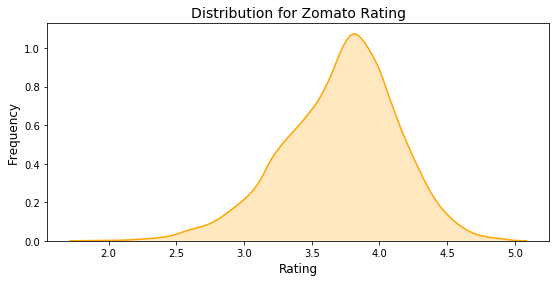

In [24]:
# Plot distribution for Rating
plt.figure(figsize=(9,4))
plt.title('Distribution for Zomato Rating', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(np.arange(0, 5.5, step=0.5))
sns.kdeplot(df['Rating'], shade=True, legend=False, color='orange');

### Distribution for restaurant cost

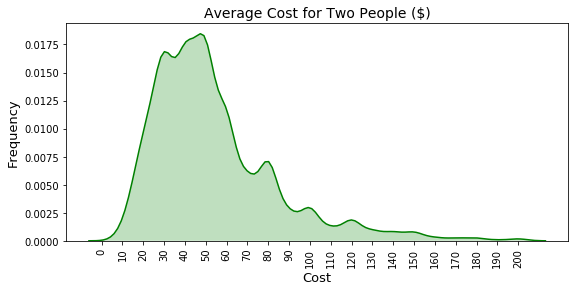

In [25]:
# Plot distribution for Cost
plt.figure(figsize=(9,4))
plt.title('Average Cost for Two People ($)', fontsize=14)
plt.xlabel('Cost', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(np.arange(0, 210, step=10), rotation=90)
sns.kdeplot(df[df['Cost'] <= 200]['Cost'], shade=True, legend=False, color='green');

### Ditribution for restaurant opening hours

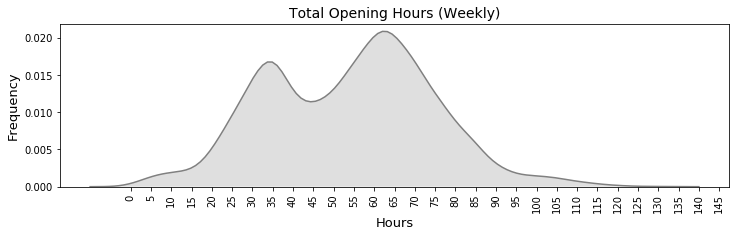

In [26]:
# Plot distribution for Total Opening Hours (Weekly)
plt.figure(figsize=(12,3))
plt.title('Total Opening Hours (Weekly)', fontsize=14)
plt.xlabel('Hours', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(np.arange(0, 150, step=5), rotation=90)
sns.kdeplot(df[(df['Total Opening Hours (Weekly)'] <= 150) & (df['Total Opening Hours (Weekly)'] > 0)]['Total Opening Hours (Weekly)'], shade=True, legend=False, color='grey');

### Distributions for reviewer input

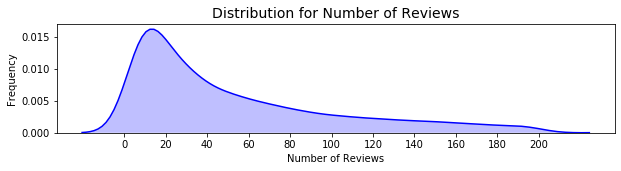

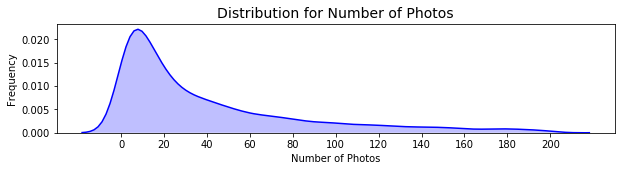

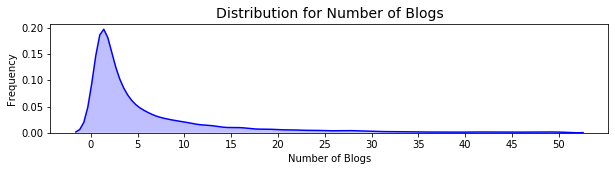

In [27]:
# Plot distribution for Number of Reviews
plt.figure(figsize=(10,2))
plt.title('Distribution for Number of Reviews', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(np.arange(0, 220, step=20))
sns.kdeplot(df[df['Number of Reviews'] <= 200]['Number of Reviews'], shade=True, legend=False, color='blue');

# Plot distribution for Number of Photos
plt.figure(figsize=(10,2))
plt.title('Distribution for Number of Photos', fontsize=14)
plt.xlabel('Number of Photos', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(np.arange(0, 220, step=20))
sns.kdeplot(df[df['Number of Photos'] <= 200]['Number of Photos'], shade=True, legend=False, color='blue');

# Plot distribution for Number of Blogs
plt.figure(figsize=(10,2))
plt.title('Distribution for Number of Blogs', fontsize=14)
plt.xlabel('Number of Blogs', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(np.arange(0, 55, step=5))
sns.kdeplot(df[df['Number of Blogs'] <= 50]['Number of Blogs'], shade=True, legend=False, color='blue');

### Distributions for reviewer sentiment

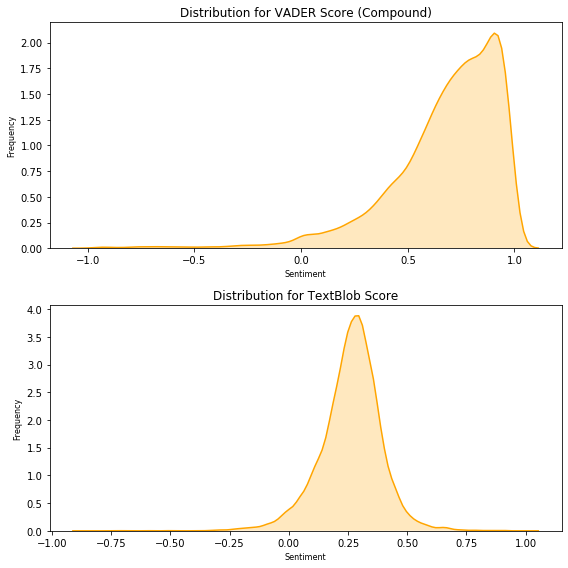

In [28]:
# Plot distribution for VADER and Textblob sentiment
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
features = ['VADER Score (Compound)','TextBlob Score']
colours = ['orange','orange']
axes = [ax1, ax2]
for feature, colour, axis in zip(features, colours, axes):
    axis.title.set_text(f'Distribution for {feature}')
    axis.set_xlabel('Sentiment', fontsize=8)
    axis.set_ylabel('Frequency', fontsize=8)
    sns.kdeplot(df[feature], shade=True, legend=False, color=colour, ax=axis);
plt.tight_layout()

### Popularity of locations

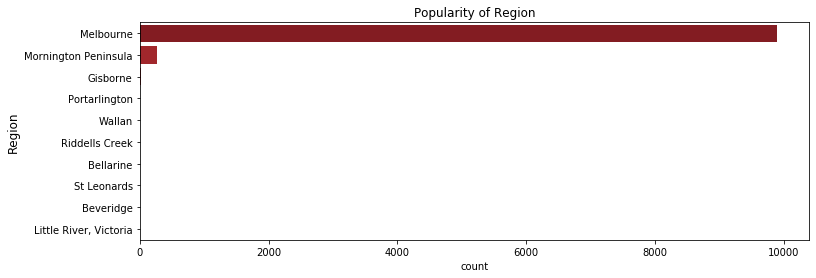

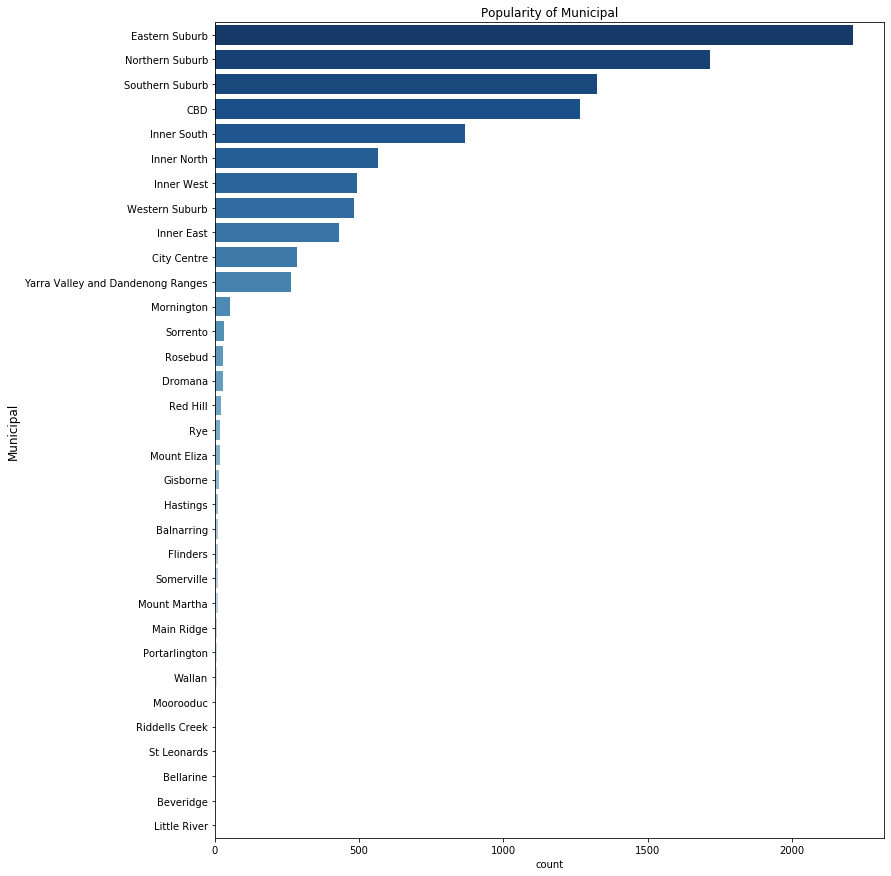

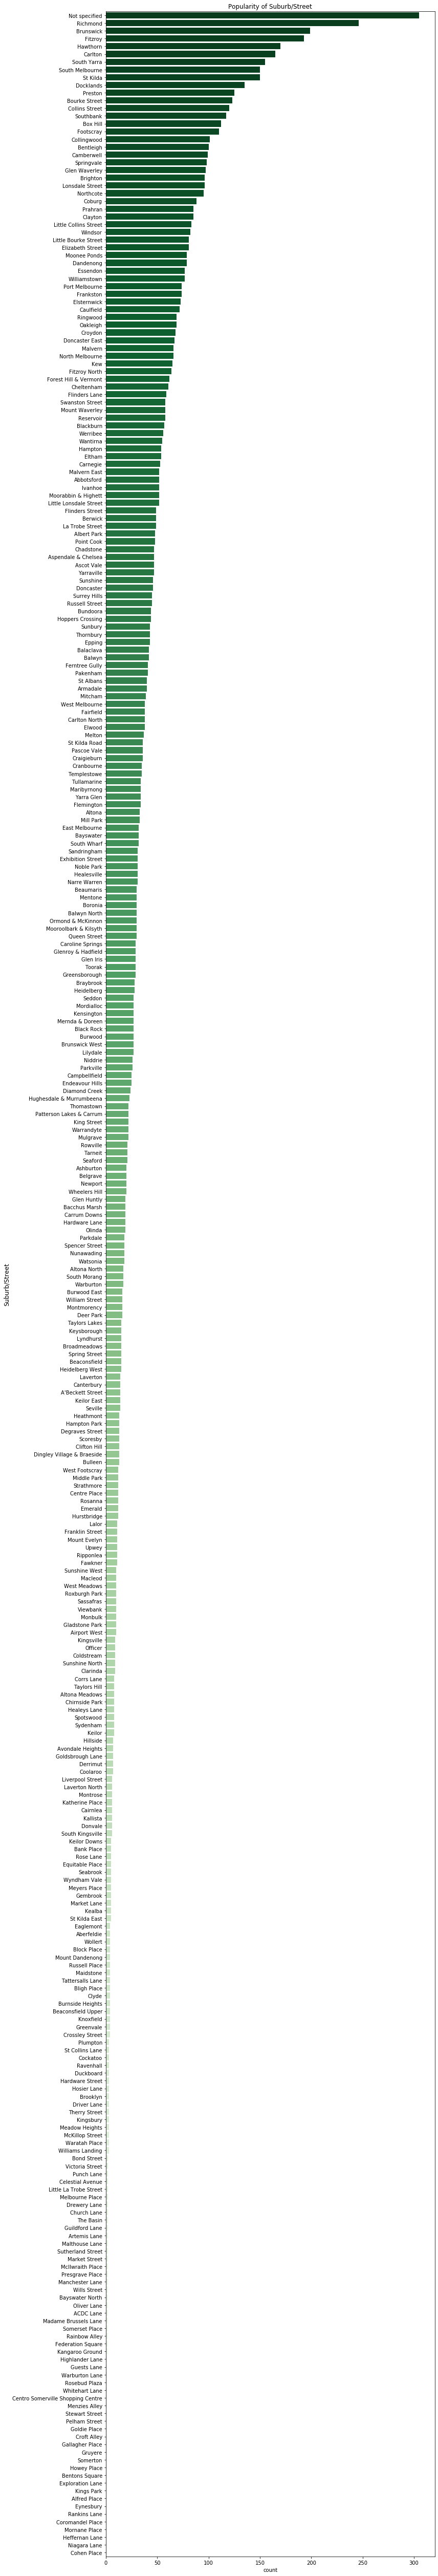

In [29]:
features = ['Location 2','Location 3', 'Location 4']
ylabels = iter(['Region','Municipal','Suburb/Street'])
titles = iter(['Region','Municipal','Suburb/Street'])
colours = iter(['Reds_r','Blues_r','Greens_r'])
fig_sizes = iter([(12,4),(12,15),(12,70)])
for feature in features:
    plt.figure(figsize=next(fig_sizes))
    ax = sns.countplot(y=df[feature], orient='v', order=df[feature].value_counts().index, palette=next(colours));
    plt.ylabel(next(ylabels), fontsize=12);
    ax.set_title(f'Popularity of {next(titles)}')
plt.tight_layout()

### Popularity of food categories and cuisines

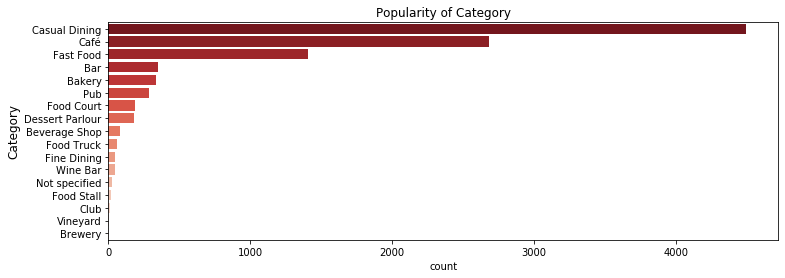

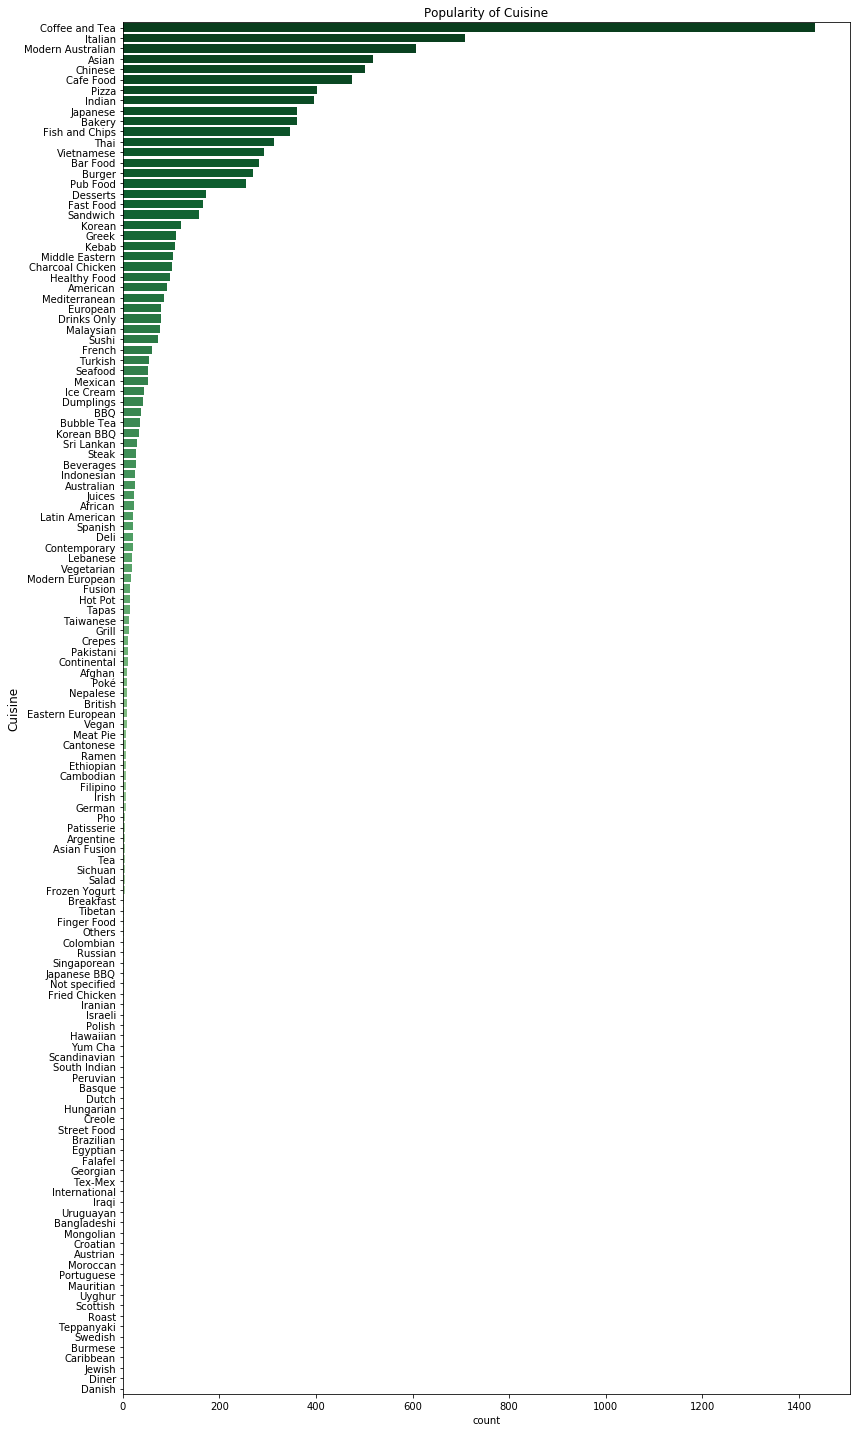

In [30]:
features = ['Category 1','Cuisine 1']
titles = iter(['Category','Cuisine'])
ylabels = iter(['Category','Cuisine'])
colours = iter(['Reds_r','Greens_r'])
fig_sizes = iter([(12,4),(12,20)])
for feature in features:
    plt.figure(figsize=next(fig_sizes))
    ax = sns.countplot(y=df[feature], orient='v', order=df[feature].value_counts().index, palette=next(colours));
    ax.set_title(f'Popularity of {next(titles)}')
    plt.ylabel(next(ylabels), fontsize=12);
plt.tight_layout()

### Relationships between opening hours and restaurant characteristics

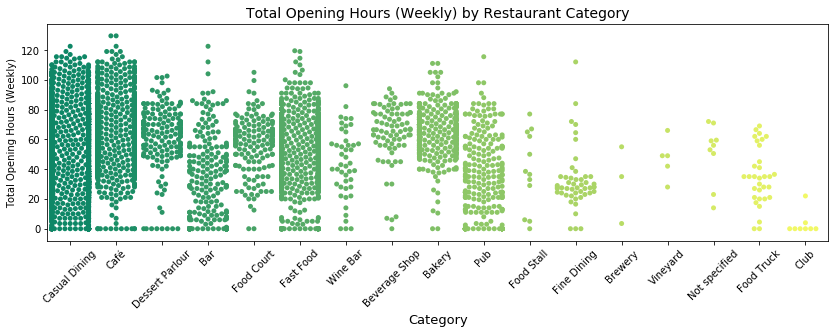

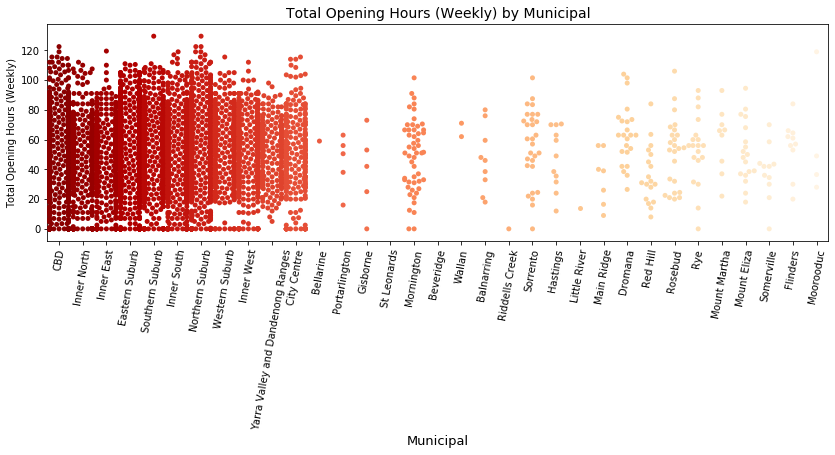

In [31]:
# Plot swarm plot of Total Opening Hours (Weekly) by Category 1
plt.figure(figsize=(14,4))
sns.swarmplot(x='Category 1', y='Total Opening Hours (Weekly)', data=df,
              palette='summer');
plt.title('Total Opening Hours (Weekly) by Restaurant Category', fontsize=14)
plt.xlabel('Category', fontsize=13)
plt.xticks(rotation=45);

plt.figure(figsize=(14,4))
sns.swarmplot(x='Location 3', y='Total Opening Hours (Weekly)', data=df,
              palette='OrRd_r');
plt.title('Total Opening Hours (Weekly) by Municipal', fontsize=14)
plt.xlabel('Municipal', fontsize=13)
plt.xticks(rotation=80);

### Relationships between Zomato rating and restaurant characteristics 

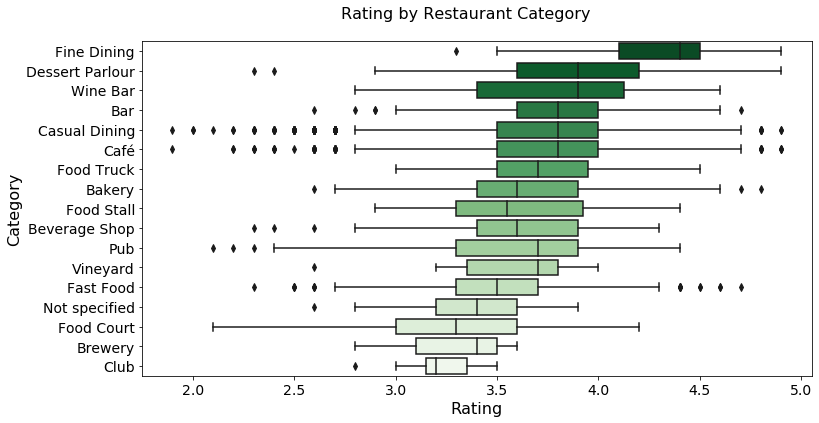

In [32]:
# Plot Rating vs. Restaurant Category
plt.figure(figsize=(12,6))
sns.boxplot(x='Rating', y='Category 1', data=df, orient='h', palette='Greens_r',
           order=df.groupby(['Category 1']).mean().sort_values('Rating', ascending=False).index);
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);
plt.xlabel('Rating', fontsize=16);
plt.ylabel('Category', fontsize=16);
plt.subplots_adjust(top=0.9)
plt.suptitle(f'Rating by Restaurant Category', fontsize = 16);

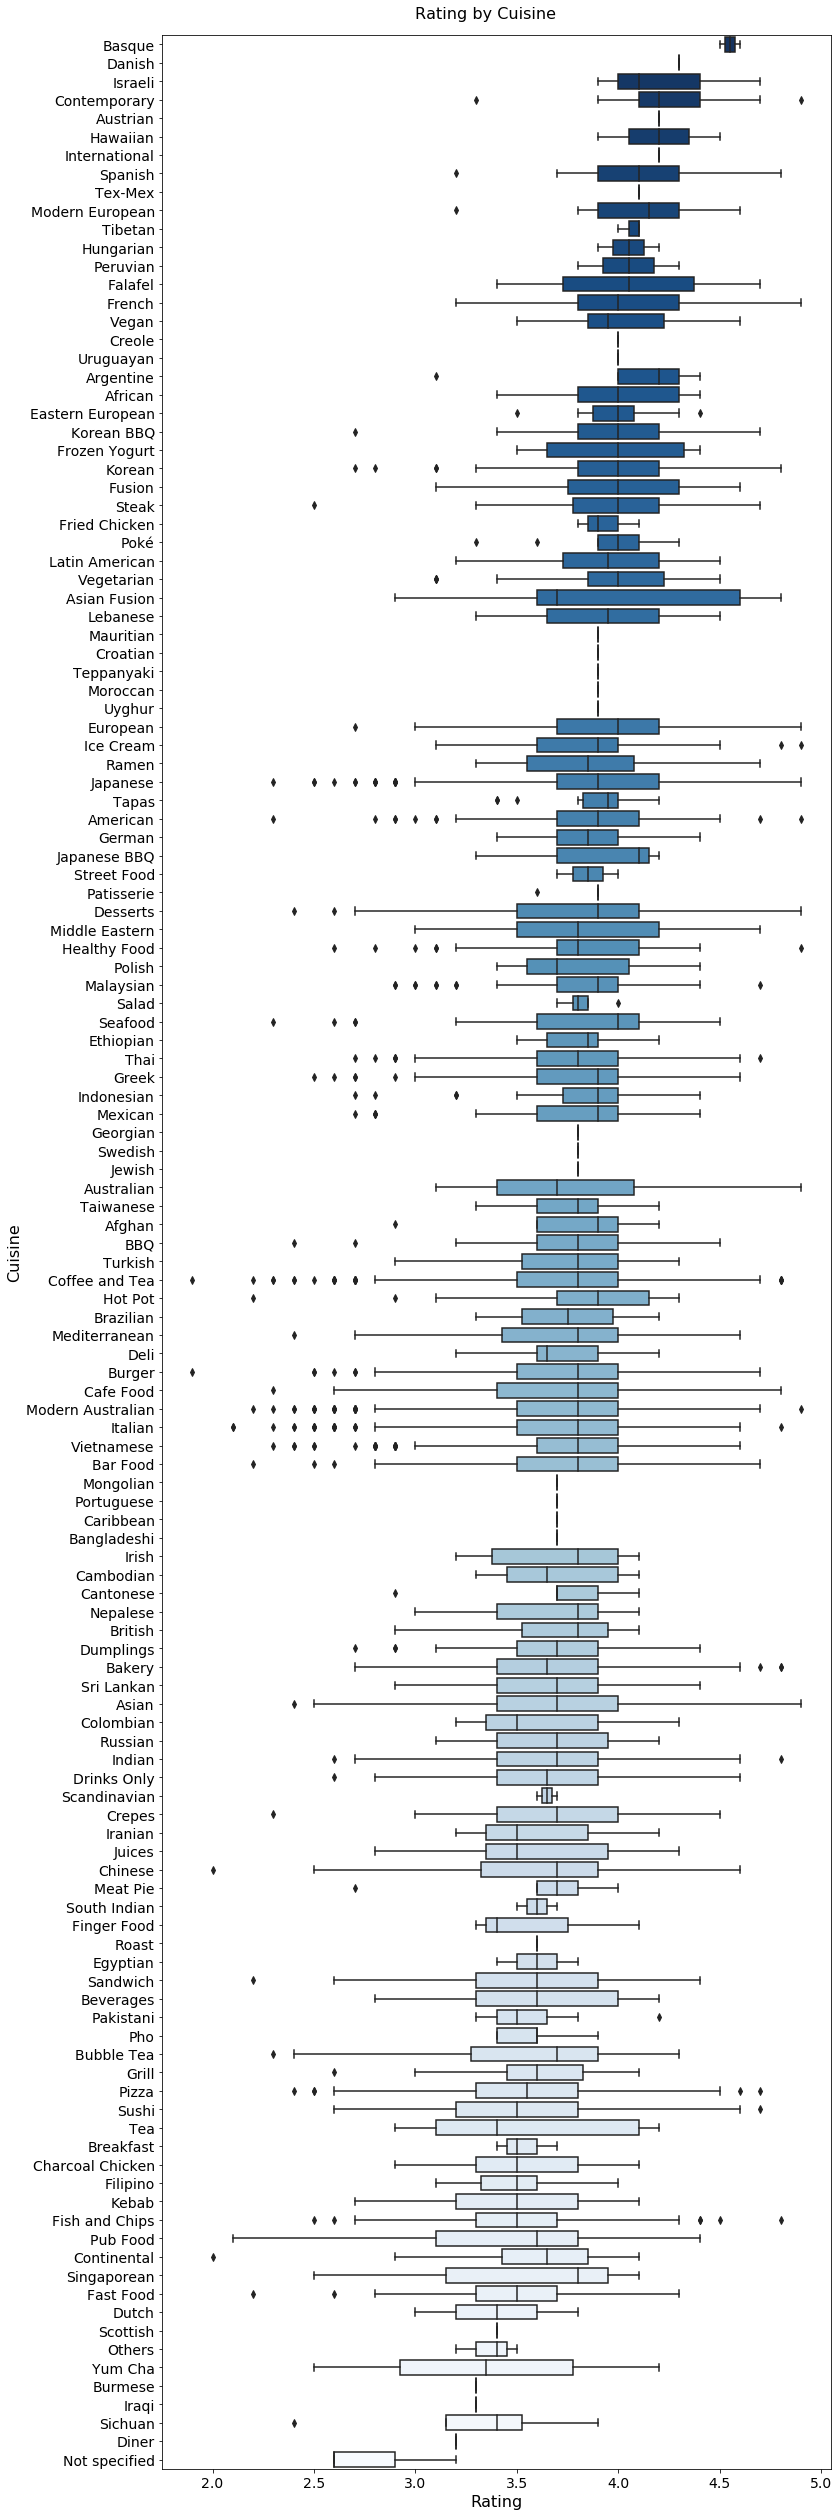

In [33]:
# Plot Rating vs. Cuisine
plt.figure(figsize=(12, 40))
sns.boxplot(x='Rating', y='Cuisine 1', data=df, orient='h', palette='Blues_r',
           order=df.groupby(['Cuisine 1']).mean().sort_values('Rating', ascending=False).index);
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);
plt.xlabel('Rating', fontsize=16);
plt.ylabel('Cuisine', fontsize=16);
plt.subplots_adjust(top=0.97)
plt.suptitle(f'Rating by Cuisine', fontsize=16);

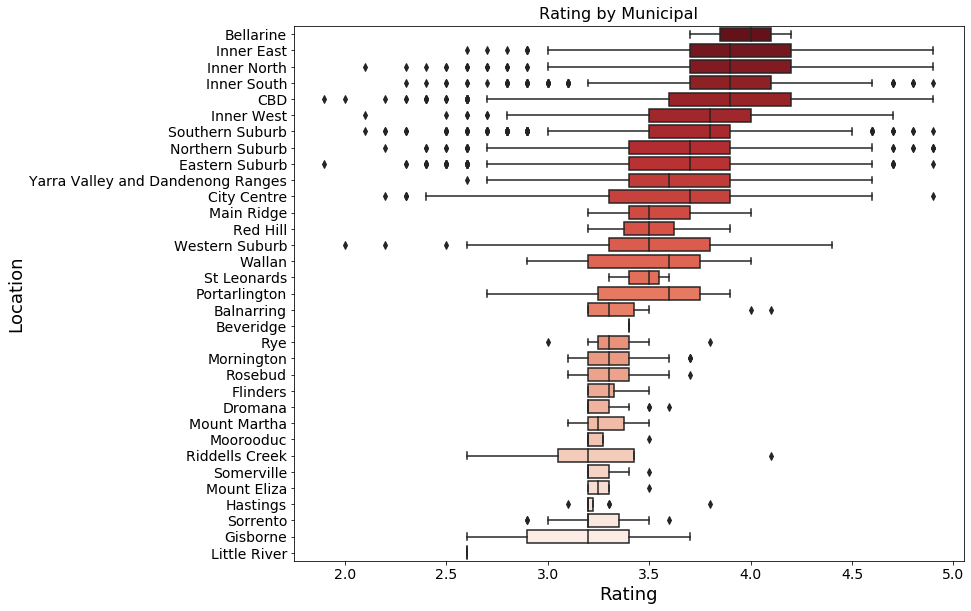

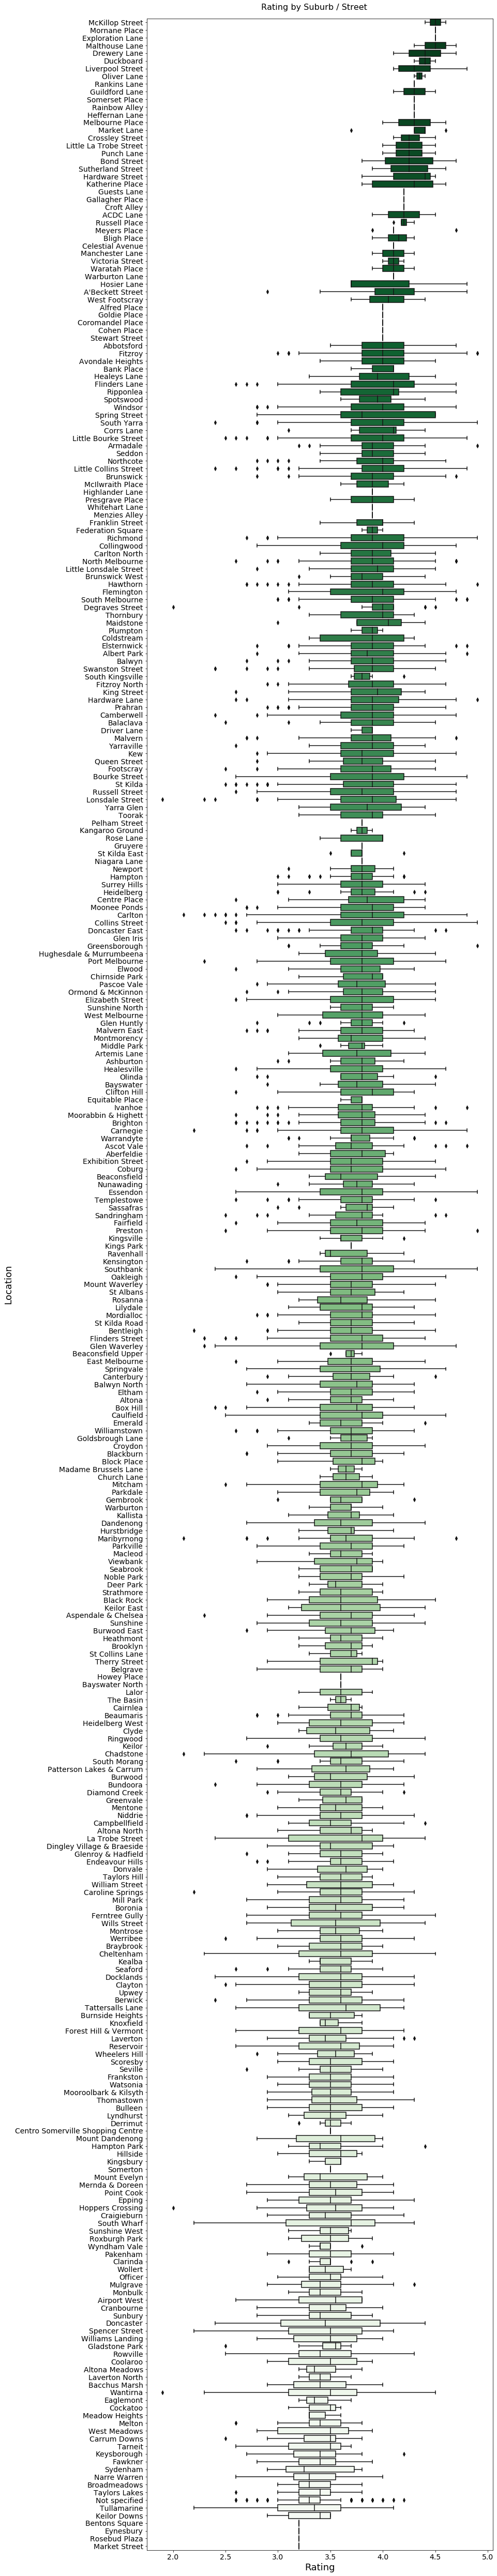

In [34]:
# Plot Rating vs. Municipal
plt.figure(figsize=(12, 9))
sns.boxplot(x='Rating', y='Location 3', data=df, orient='h', palette='Reds_r',
           order=df.groupby(['Location 3']).mean().sort_values('Rating', ascending=False).index);
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);
plt.xlabel('Rating', fontsize=18);
plt.ylabel('Location', fontsize=18);
plt.subplots_adjust(top=0.95)
plt.suptitle(f'Rating by Municipal', fontsize=16);

# Plot Rating vs. Suburb / Street
plt.figure(figsize=(12, 80))
sns.boxplot(x='Rating', y='Location 4', data=df, orient='h', palette='Greens_r',
           order=df.groupby(['Location 4']).mean().sort_values('Rating', ascending=False).index);
plt.tick_params(axis = 'both', which = 'major', labelsize = 14);
plt.xlabel('Rating', fontsize=18);
plt.ylabel('Location', fontsize=18);
plt.subplots_adjust(top=0.975)
plt.suptitle(f'Rating by Suburb / Street', fontsize=16);

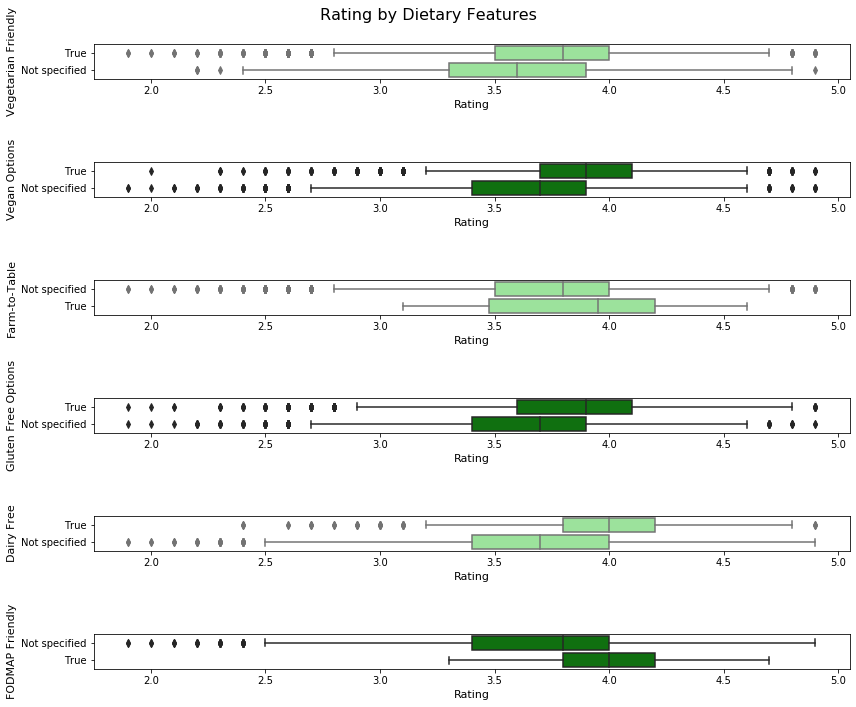

In [35]:
# Plot relationships between dietary features and Rating
categorical_features = ['Vegetarian Friendly','Vegan Options','Farm-to-Table','Gluten Free Options','Dairy Free','FODMAP Friendly']
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize=(12,10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
colours = iter(['lightgreen','green','lightgreen','green','lightgreen','green'])
for feature, axis in zip(categorical_features, axes):
    #axis.title.set_text(f'Rating by {feature}')
    sns.boxplot(x='Rating', y=feature, data=df, orient='h', ax=axis, color=next(colours));
    axis.set_xlabel('Rating', fontsize=11)
    axis.set_ylabel(feature, fontsize=11)
plt.subplots_adjust(top=0.4)
fig.suptitle('Rating by Dietary Features', fontsize=16)
plt.tight_layout()

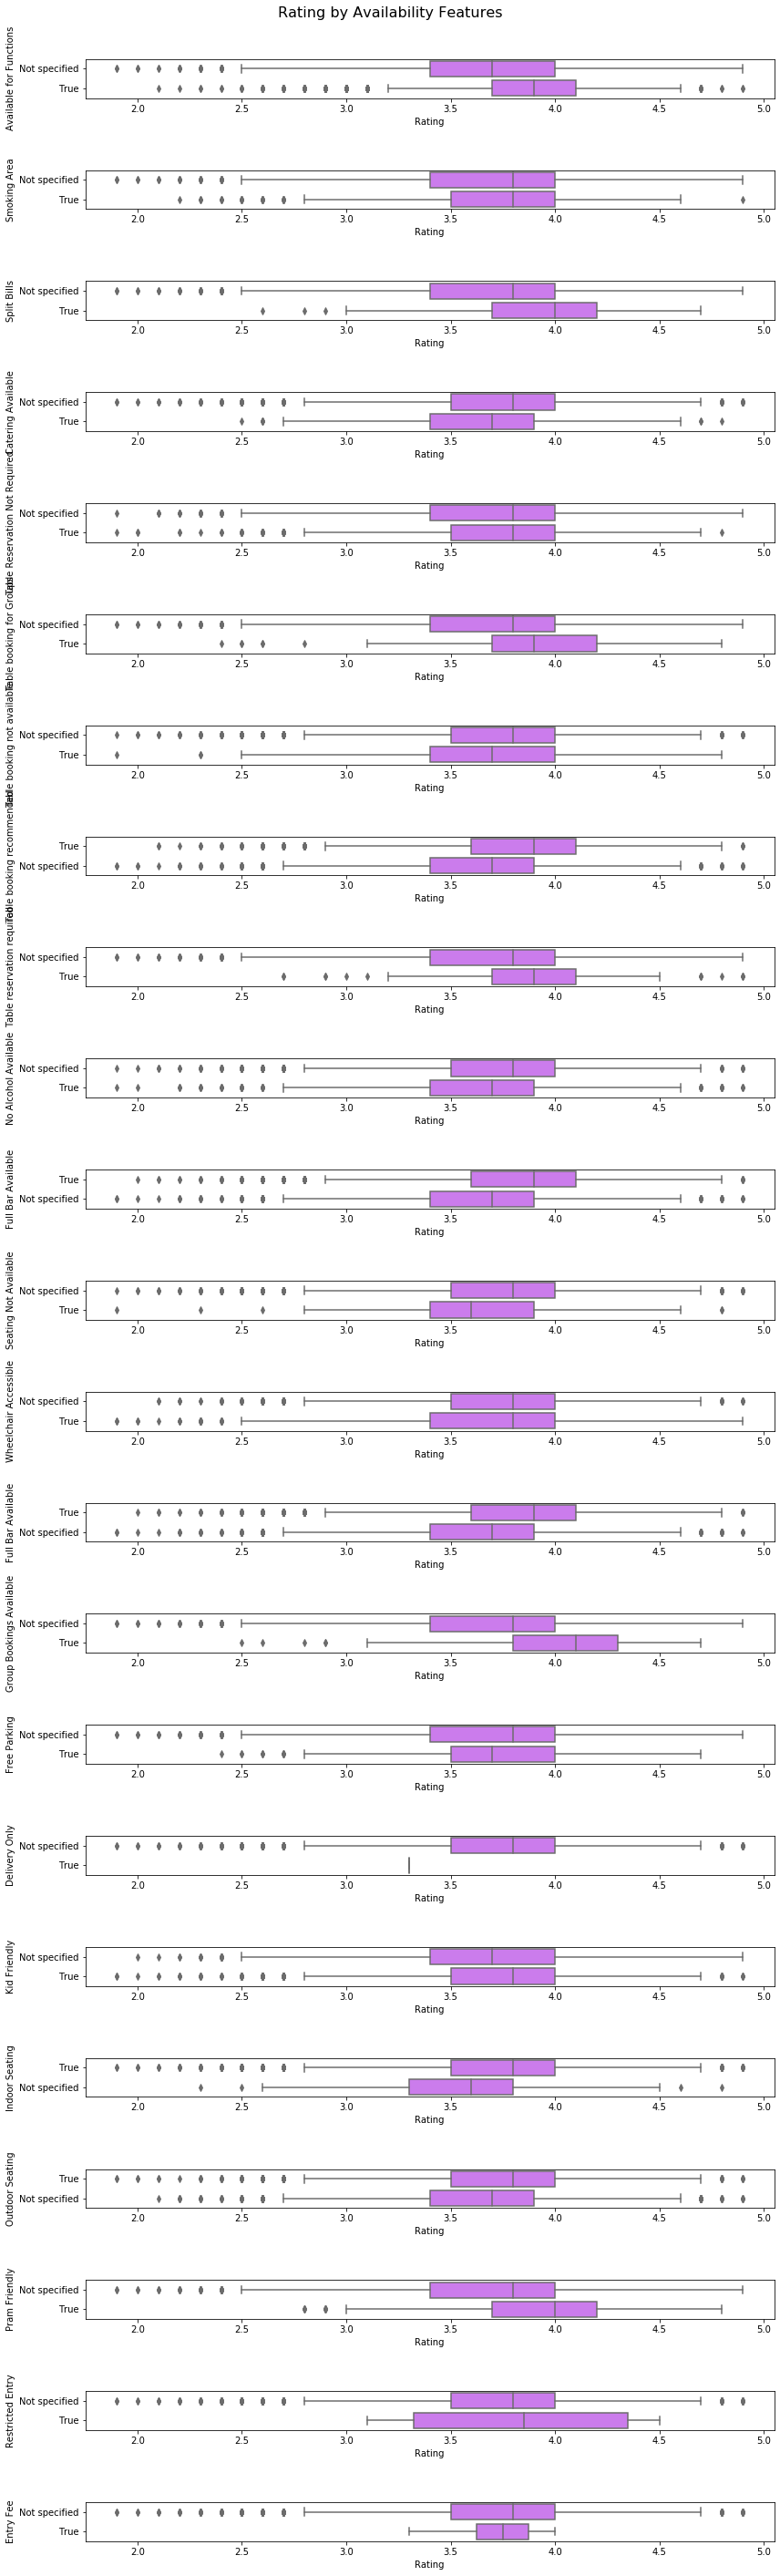

In [36]:
# Plot relationships between availability features and Rating
features = ['Available for Functions',
            'Smoking Area',
            'Split Bills',
            'Catering Available',
            'Table Reservation Not Required',
            'Table booking for Groups',
            'Table booking not available',
            'Table booking recommended',
            'Table reservation required',
            'No Alcohol Available',
            'Full Bar Available',
            'Seating Not Available',
            'Wheelchair Accessible',
            'Full Bar Available',
            'Group Bookings Available',
            'Free Parking',
            'Delivery Only',
            'Kid Friendly',
            'Indoor Seating',
            'Outdoor Seating',
            'Pram Friendly',
            'Restricted Entry',
            'Entry Fee']

fig, axes = plt.subplots(len(features), 1, figsize=(12,40))
for i, feature in enumerate(features):
    sns.boxplot(x='Rating', y=feature, data=df, orient='h', ax=axes[i], color='#d269ff');
    axis.set_xlabel('Rating', fontsize=16)
    axis.set_ylabel(feature, fontsize=16)
plt.tight_layout()
fig.suptitle('Rating by Availability Features', fontsize=16, size=16)
fig.subplots_adjust(top=0.96)

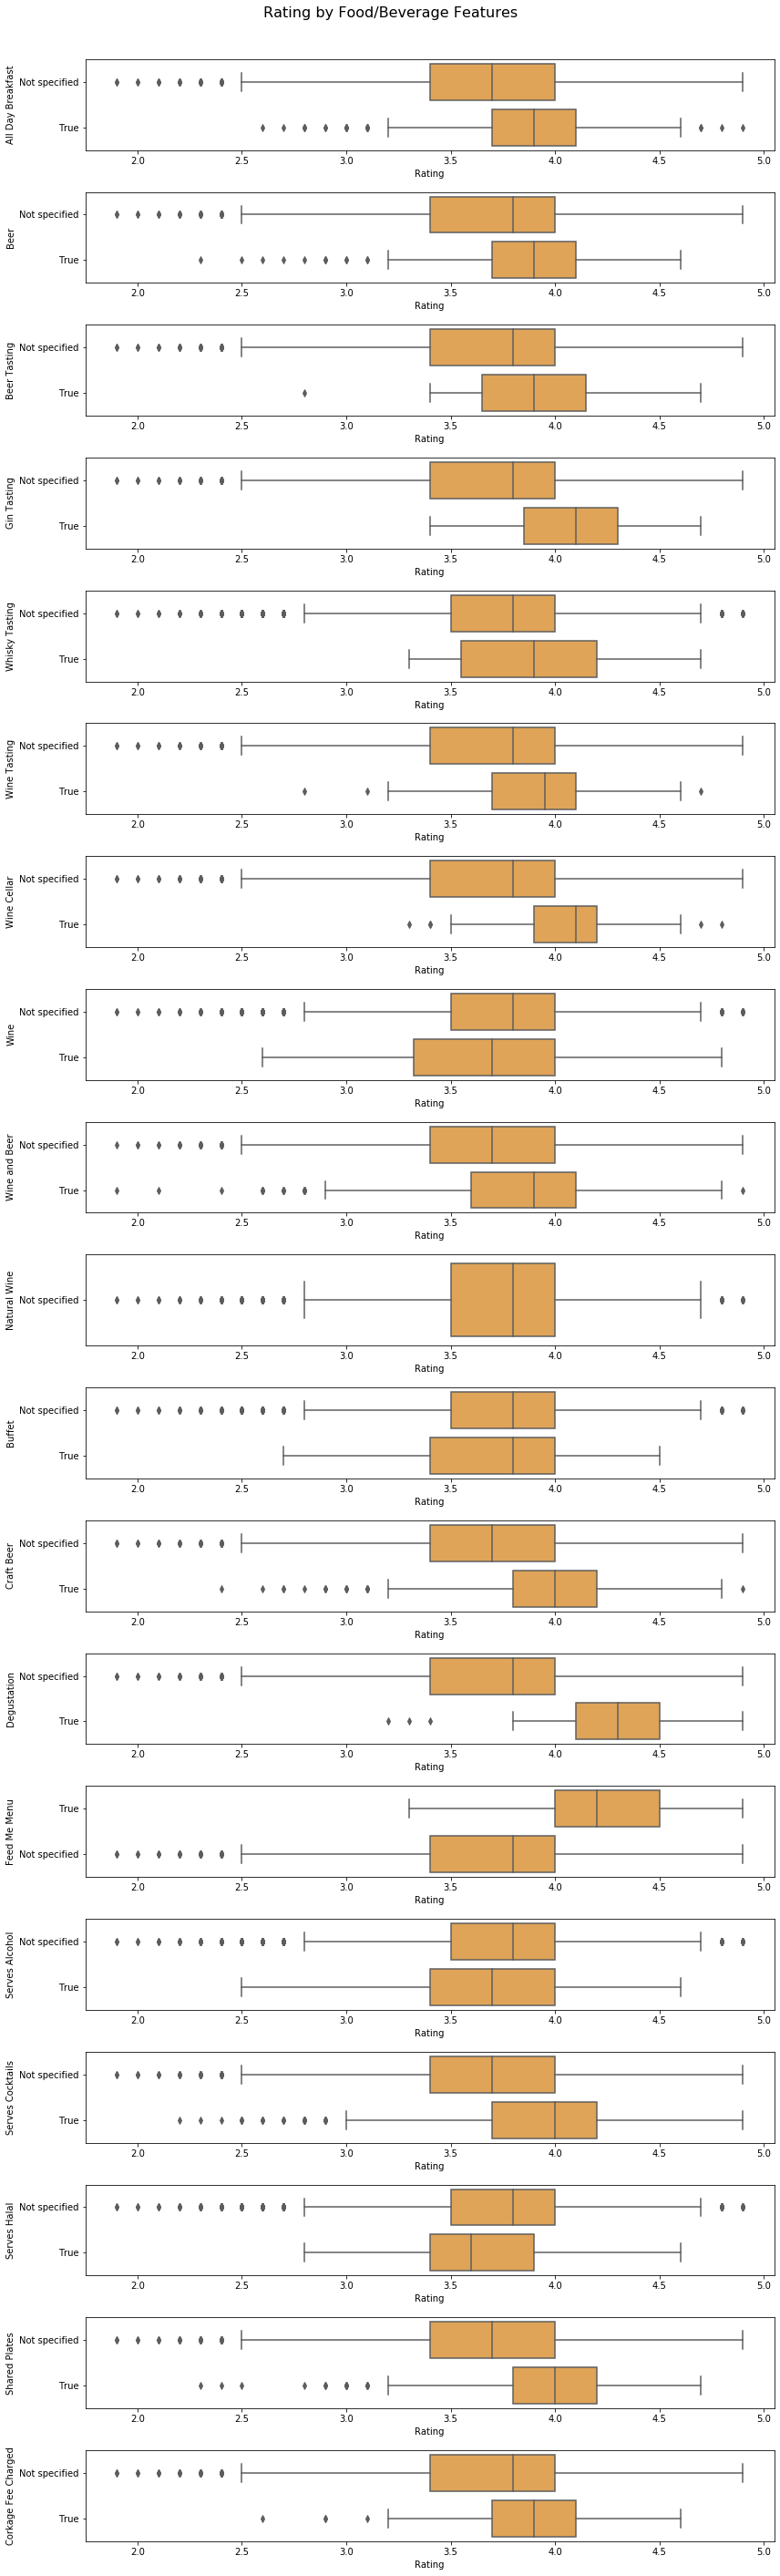

In [37]:
# Plot relationships between food/beverage features and Rating
features = ['All Day Breakfast',
            'Beer',
            'Beer Tasting',
            'Gin Tasting',
            'Whisky Tasting',
            'Wine Tasting',
            'Wine Cellar',
            'Wine',
            'Wine and Beer',
            'Natural Wine',
            'Buffet',
            'Craft Beer',
            'Degustation',
            'Feed Me Menu',
            'Serves Alcohol',
            'Serves Cocktails',
            'Serves Halal',
            'Shared Plates',
            'Corkage Fee Charged']

fig, axes = plt.subplots(len(features), 1, figsize=(12,40))
for i, feature in enumerate(features):
    sns.boxplot(x='Rating', y=feature, data=df, orient='h', ax=axes[i], color='#f5a742');
    axis.set_xlabel('Rating', fontsize=16)
    axis.set_ylabel(feature, fontsize=16)
plt.tight_layout()
fig.suptitle('Rating by Food/Beverage Features', fontsize=16, size=16)
fig.subplots_adjust(top=0.96)

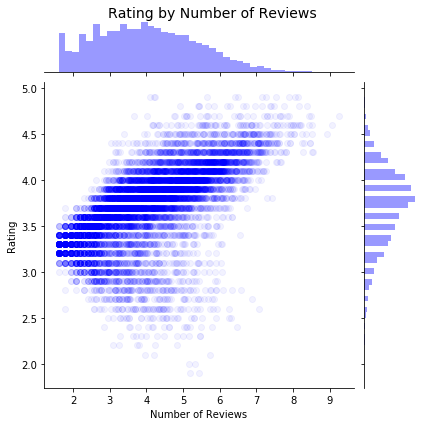

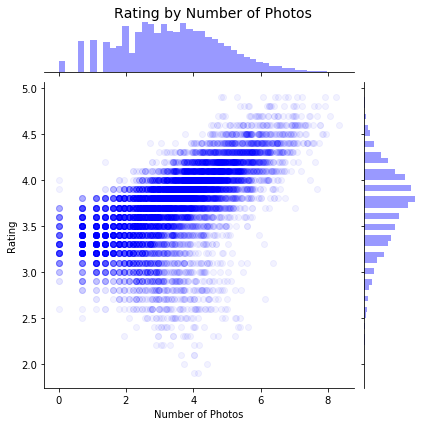

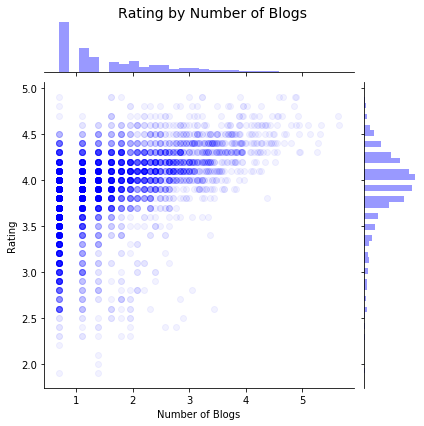

In [38]:
# Plot distributions between Rating and reviewer input
sns.jointplot(np.log1p(df['Number of Reviews']), df['Rating'], alpha=0.05, color='blue');
plt.subplots_adjust(top=0.95)
plt.suptitle('Rating by Number of Reviews', fontsize = 14);

sns.jointplot(np.log1p(df['Number of Photos']), df['Rating'], alpha=0.05, color='blue');
plt.subplots_adjust(top=0.95)
plt.suptitle('Rating by Number of Photos', fontsize = 14);

sns.jointplot(np.log1p(df['Number of Blogs']), df['Rating'], alpha=0.05, color='blue');
plt.subplots_adjust(top=0.95)
plt.suptitle('Rating by Number of Blogs', fontsize = 14);

We can see an interesting relationship in the first two graphs (above). A higher number of reviews and photos is associated with both an increase _and_ decrease in restaurant ratings. One may hypothesise that customers are motivated to leave restaurant ratings and upload photos when a restaurant experience is remembered as either highly positive or highly negative; restaurant experiences that are just "okay" may not motivate as much action from the customer.

To further explore this hypothesis, we will add sentiment as a grouping factor to the graphs. We can see that many of the restaurants with positive sentiment are clustered in the top of the graph, whereas those with negative sentiment are clustered in the bottom of the graph. This finding supports the hypothesis that both positive and negative sentiment motivates customers to leave restaurant reviews and photo uploads.

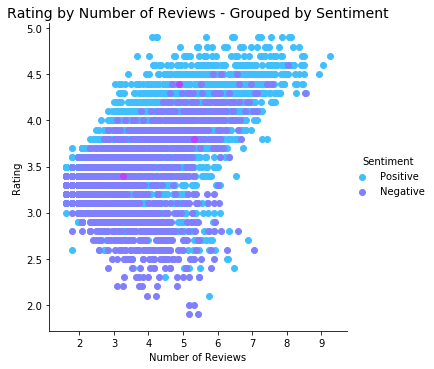

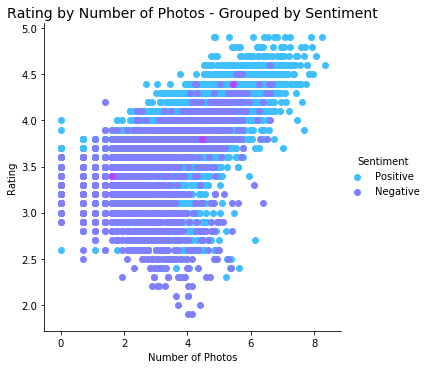

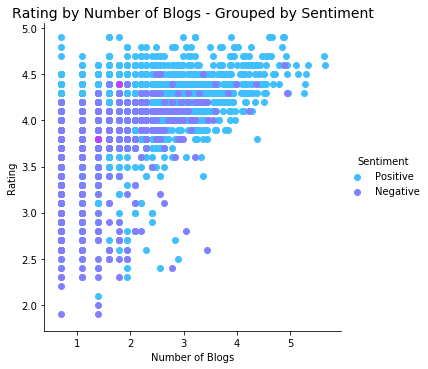

In [39]:
df_transformed = df.copy()
df_transformed['Number of Reviews'] = np.log1p(df['Number of Reviews'])
df_transformed['Number of Photos'] = np.log1p(df['Number of Photos'])
df_transformed['Number of Blogs'] = np.log1p(df['Number of Blogs'])
df_transformed.rename(columns={'TextBlob Score (Categorical)':'Sentiment'}, inplace=True)

sns.lmplot(x='Number of Reviews', y='Rating', hue='Sentiment', data=df_transformed,
           scatter_kws={'alpha':1}, fit_reg=False, size=5, palette='cool');
plt.title('Rating by Number of Reviews - Grouped by Sentiment', fontsize = 14);

sns.lmplot(x='Number of Photos', y='Rating', hue='Sentiment', data=df_transformed,
           scatter_kws={'alpha':1}, fit_reg=False, size=5, palette='cool');
plt.title('Rating by Number of Photos - Grouped by Sentiment', fontsize = 14);

sns.lmplot(x='Number of Blogs', y='Rating', hue='Sentiment', data=df_transformed,
           scatter_kws={'alpha':1}, fit_reg=False, size=5, palette='cool');
plt.title('Rating by Number of Blogs - Grouped by Sentiment', fontsize = 14);

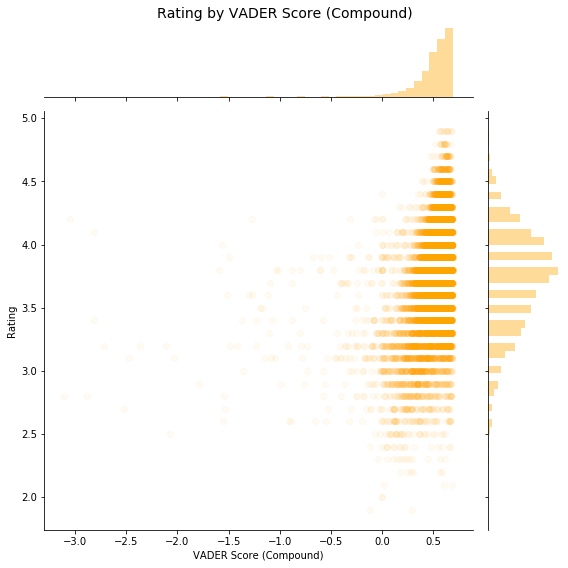

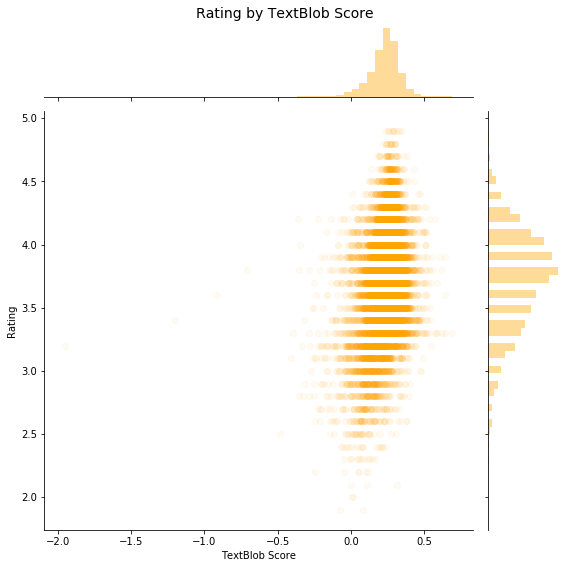

In [40]:
# Plot scatterplots between sentiment scores and Rating
for feature in ['VADER Score (Compound)','TextBlob Score']:
    sns.jointplot(np.log1p(df[feature]), df['Rating'], alpha=0.05, size=8, color='orange');
    plt.subplots_adjust(top=0.95)
    plt.suptitle(f'Rating by {feature}', fontsize = 14);

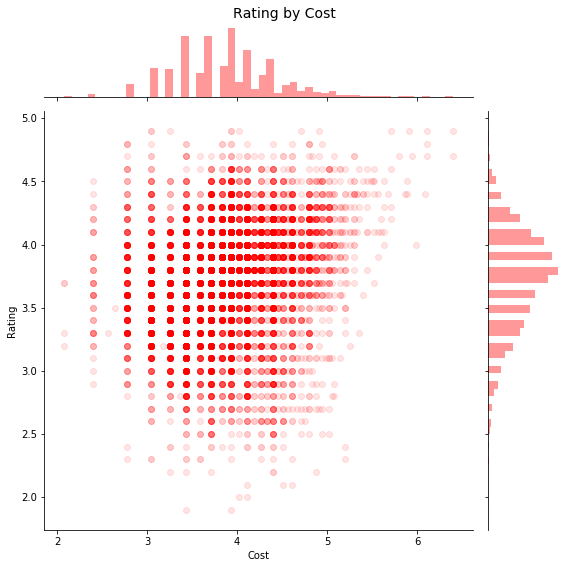

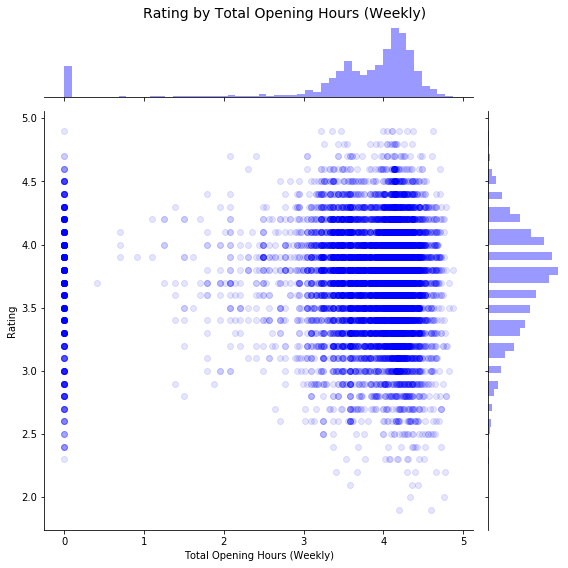

In [41]:
# Plot scatterplots between select features and Rating
colours = iter(['Red','Blue'])
for feature in ['Cost','Total Opening Hours (Weekly)']:
    sns.jointplot(np.log1p(df[feature]), df['Rating'], alpha=0.1, size=8, color=next(colours));
    plt.subplots_adjust(top=0.95)
    plt.suptitle(f'Rating by {feature}', fontsize = 14);

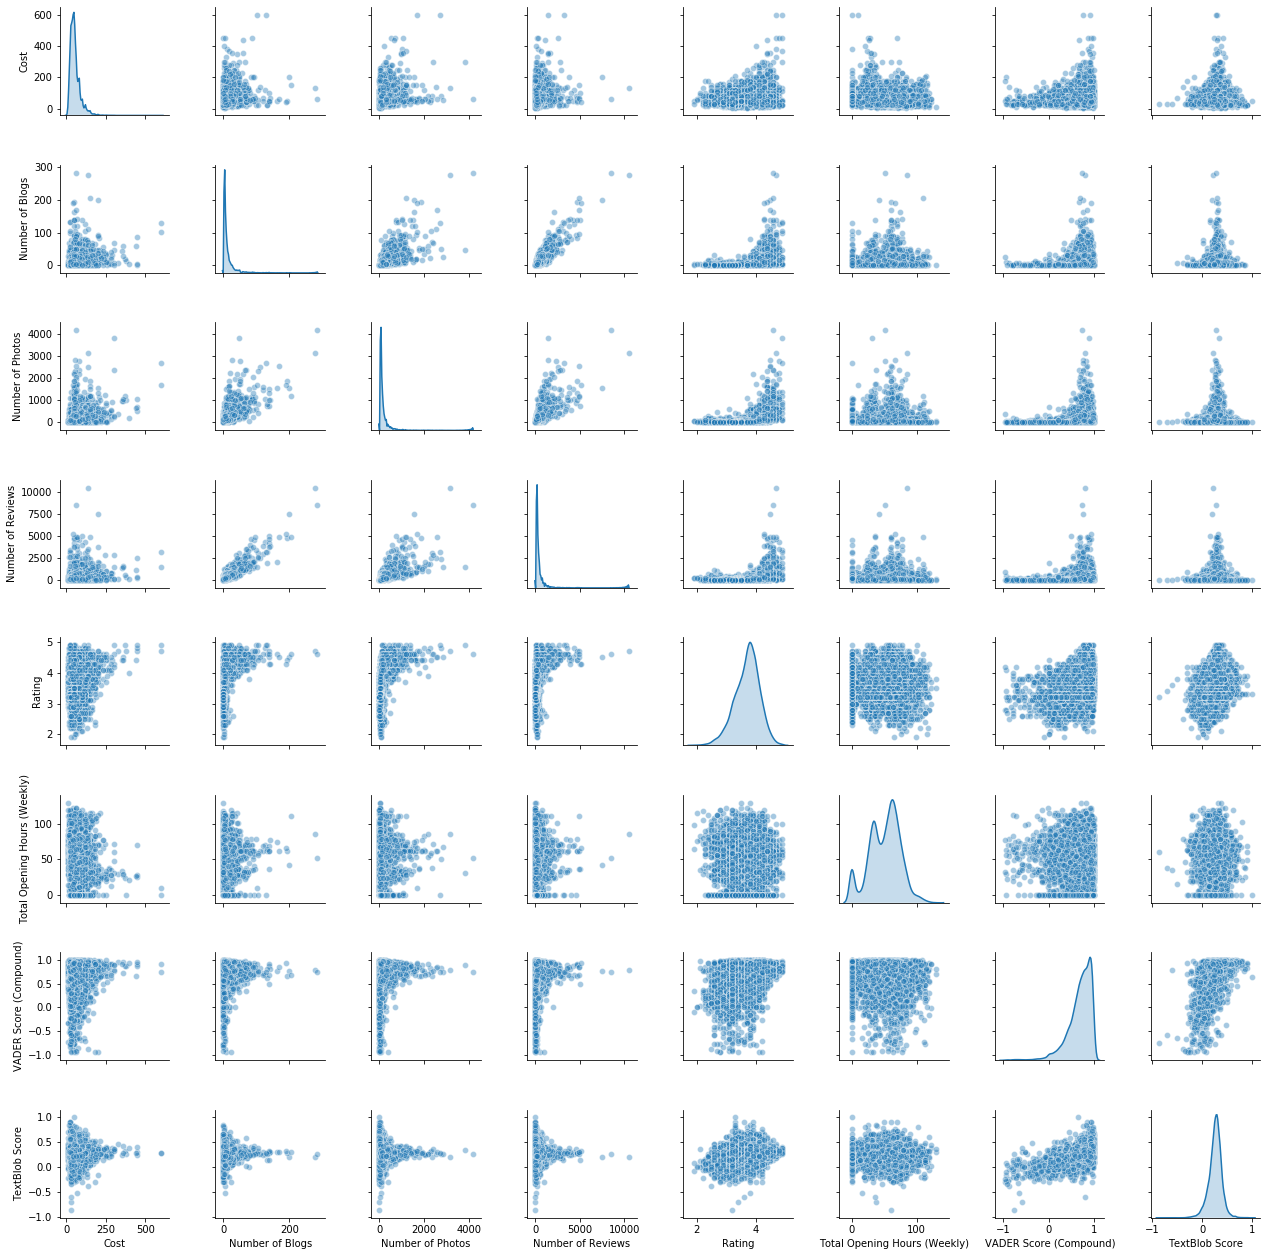

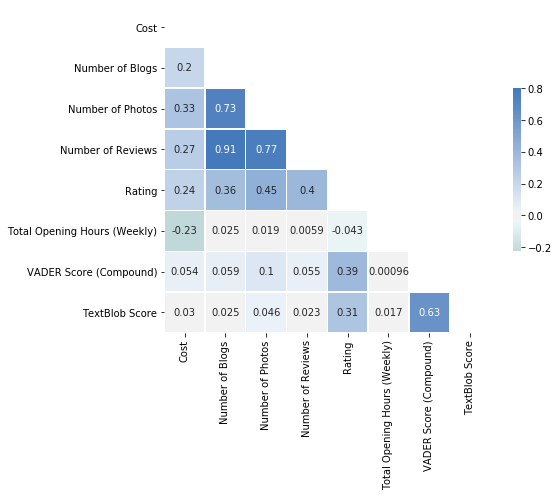

In [42]:
# Plot pairwise associations between quantitative features
sns.pairplot(df, diag_kind='kde', palette='Greens',
             plot_kws={'alpha':0.4},
             diag_kws={'shade':True}, size=2.2);

# Correlation matrix of numerical features
corrmat = df.corr()
f, ax = plt.subplots(figsize=(8, 6))
mask = np.zeros_like(corrmat, dtype=np.bool) # generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
# Set colour palette
cmap = sns.diverging_palette(200, 250, as_cmap=True)
sns.heatmap(corrmat, vmax=.8, center = 0, mask=mask, square=True, linewidths=.5, annot=True,
            cmap=cmap, cbar_kws={"shrink":0.5});
# Fix issue whereby heatmap is "cut off"
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

In [43]:
# Get the lowest rated restaurants
df[df['Rating'] < 2]['Name']

2512         The Coffee Club
9482    Goody's Burger House
Name: Name, dtype: object

In [44]:
# Get the highest rated restaurants
df[df['Rating'] > 4.8]['Name']

183              Infuse Greensborough
1601                       Bowls Baby
2199                   Gelato Messina
2208                            Amaru
2800                          Gabriel
3109                           Dexter
4630                    Shanklin Cafe
4632      Dinner by Heston Blumenthal
4638                      Minamishima
4776    Burch & Purchese Sweet Studio
5577                  La Belle Miette
9064                     Vue de monde
Name: Name, dtype: object

## Predictive Modelling

In [45]:
# Drop features unneeded for prediction
df.drop(columns=['Known For','TextBlob Score (Categorical)'], inplace=True)

In [46]:
# Preprocessing libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import Imputer, StandardScaler

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin
class ColumnSelector(BaseEstimator, TransformerMixin):
    """A custom transformer to select a subset of columns"""
    def __init__(self, subset):
        self.subset = subset

    def transform(self, X, *_):
        return X.loc[:, self.subset]

    def fit(self, *_):
        return self

In [47]:
# Pipeline to preprocess numerical features
num_features = df.select_dtypes(include=['int64','float64']).columns
num_pipeline = Pipeline([
        ('selector', ColumnSelector(num_features)), 
        ('imputer', Imputer(strategy="median")),           
        ('standardizer', StandardScaler())        
    ])

# Pipeline to preprocess categorical features
cat_features = [feat for feat in df.columns if feat not in num_features]
cat_pipeline = Pipeline([
        ('selector', ColumnSelector(cat_features)),
        ('ordinal_encoder', OrdinalEncoder()) # more preferable than OHE for decision-tree algorithms
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])

# Get response vector
df_y = df['Rating']
# Get feature matrix
df_X = full_pipeline.fit_transform(df.drop(columns='Rating'))

# Get train and test sets (90% - 10%)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.10)
print(f'Size of training set: {X_train.shape[0]}')
print(f'Size of test set: {X_test.shape[0]}')

Size of training set: 9187
Size of test set: 1021


In [48]:
# # # # RIDGE REGRESSION # # # #
param_grid = [{'alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 100]}]

# CV hyperparamater tuning for ridge regression
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
ridge_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for ridge regression: {round(np.sqrt(-cvres["mean_test_score"].max()),2)}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 0.30992011942895875, {'alpha': 0.005}
RMSE: 0.3099180931980729, {'alpha': 0.01}
RMSE: 0.30990262549486763, {'alpha': 0.05}
RMSE: 0.30988495023587637, {'alpha': 0.1}
RMSE: 0.30982784714398126, {'alpha': 0.3}
RMSE: 0.3097105154029904, {'alpha': 1}
RMSE: 0.30956288418392025, {'alpha': 3}
RMSE: 0.30948499569620025, {'alpha': 5}
RMSE: 0.30937155947033546, {'alpha': 10}
RMSE: 0.30930469887724443, {'alpha': 15}
RMSE: 0.30921041615192846, {'alpha': 30}
RMSE: 0.3091850640838009, {'alpha': 50}
RMSE: 0.3092824979734317, {'alpha': 100}

Best RMSE for ridge regression: 0.31
Best hyperparameter(s): {'alpha': 50}


In [49]:
# # # # LASSO REGRESSION # # # #
param_grid = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# CV hyperparamater tuning for lasso regression
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
lasso_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for lasso regression: {round(np.sqrt(-cvres["mean_test_score"].max()),2)}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 0.3094281780867715, {'alpha': 0.0001}
RMSE: 0.30997205429919555, {'alpha': 0.001}
RMSE: 0.31781551362482685, {'alpha': 0.01}
RMSE: 0.35498623112375893, {'alpha': 0.1}
RMSE: 0.3883717226649566, {'alpha': 1}
RMSE: 0.39617613042915795, {'alpha': 10}
RMSE: 0.3976125724016716, {'alpha': 100}
RMSE: 0.4195826347756218, {'alpha': 1000}

Best RMSE for lasso regression: 0.31
Best hyperparameter(s): {'alpha': 0.0001}


In [50]:
# # # # XGBOOST REGRESSOR # # # #
param_grid = [
    {'n_estimators': [100, 200, 500],
     'max_depth': range(1,12,2)}]

# CV hyperparameter tuning for XGB
xgb = XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xgb, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
xgb_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score)}, {param}')
print(f'\nBest RMSE for XGBoost regressor: {round(np.sqrt(-cvres["mean_test_score"].max()),2)}')
print(f'Best hyperparameter(s):', grid_search.best_params_)

RMSE: 0.2631225881101903, {'max_depth': 1, 'n_estimators': 100}
RMSE: 0.25646476270373203, {'max_depth': 1, 'n_estimators': 200}
RMSE: 0.2528049368731009, {'max_depth': 1, 'n_estimators': 500}
RMSE: 0.24557751498944358, {'max_depth': 3, 'n_estimators': 100}
RMSE: 0.24338919814119234, {'max_depth': 3, 'n_estimators': 200}
RMSE: 0.24380550928672143, {'max_depth': 3, 'n_estimators': 500}
RMSE: 0.2435540399972525, {'max_depth': 5, 'n_estimators': 100}
RMSE: 0.24363698012872884, {'max_depth': 5, 'n_estimators': 200}
RMSE: 0.2460025612736107, {'max_depth': 5, 'n_estimators': 500}
RMSE: 0.24603447640211606, {'max_depth': 7, 'n_estimators': 100}
RMSE: 0.24658599640264942, {'max_depth': 7, 'n_estimators': 200}
RMSE: 0.2479197472124103, {'max_depth': 7, 'n_estimators': 500}
RMSE: 0.24680939880516164, {'max_depth': 9, 'n_estimators': 100}
RMSE: 0.2470302950603048, {'max_depth': 9, 'n_estimators': 200}
RMSE: 0.24774791013704117, {'max_depth': 9, 'n_estimators': 500}
RMSE: 0.24828562302914642, {'ma

RMSE on test dataset: 0.25
R-squared on test dataset: 0.64


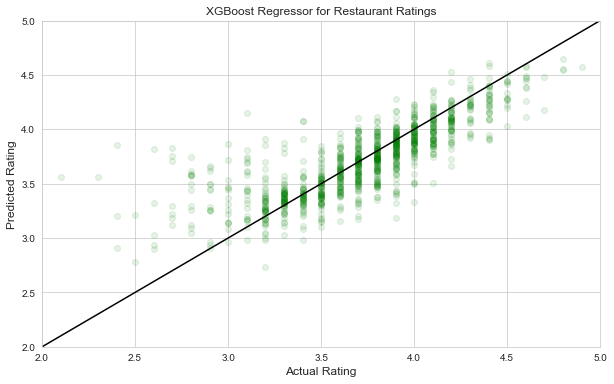

In [51]:
# Predict best model on test set
y_pred = xgb_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE on test dataset:', round(rmse, 2))
r_sq = r2_score(y_test, y_pred)
print('R-squared on test dataset:', round(r_sq, 2))

# Plot actual vs. predicted
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(y_test, y_pred, ci=None, fit_reg=False, color='green', marker='o',  scatter_kws={'alpha':0.1});
plt.title('XGBoost Regressor for Restaurant Ratings', fontsize=12);
plt.xlabel('Actual Rating', fontsize=12);
plt.ylabel('Predicted Rating', fontsize=12);
plt.xlim(2, 5);
plt.ylim(2, 5);

# Add y=x line, representing perfect prediction accuracy
y_lim = plt.ylim();
x_lim = plt.xlim();
plt.plot(x_lim, y_lim, '-', color = 'k');

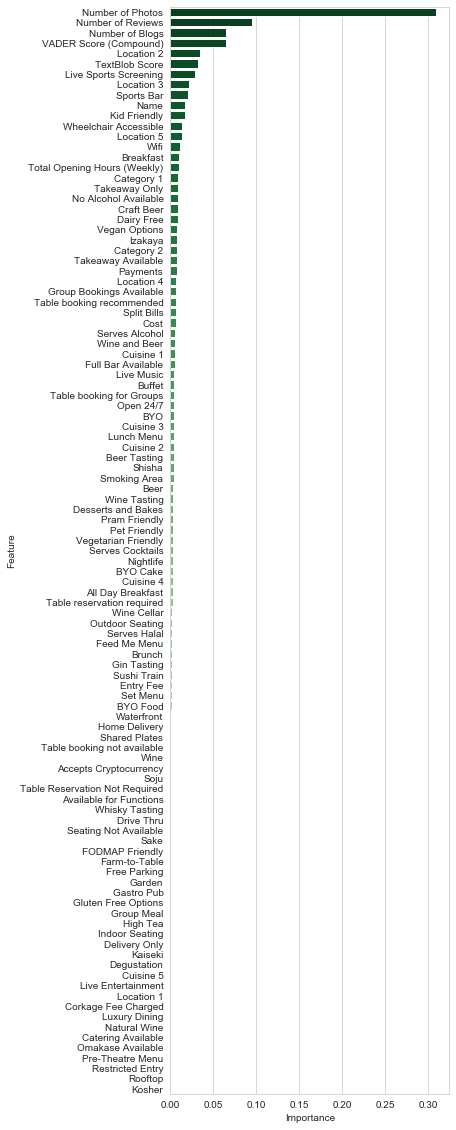

In [52]:
# Fit best model on the entire dataset
xgb_best.fit(df_X, df_y)

# Obtain and sort feature importances
all_features = list(num_features.values) + list(cat_features)
all_features.remove('Rating')
df_importances = pd.DataFrame(xgb_best.feature_importances_, all_features).reset_index(drop=False)
df_importances.rename(columns={'index':'Feature', 0:'Importance'}, inplace=True)
df_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(5,20))
sns.barplot(x='Importance', y='Feature', data=df_importances, orient='h', palette='Greens_r');

We have modest prediction accuracy when using _all_ available features. However, it may be of interest to be able to predict a restaurant's rating on solely the basis of its characteristics (e.g. location, cuisine), and not features that are unavailable at the time of Zomato listing (e.g. number of photos and reviews). Hence, we will refit our model using only restaurant characteristics.

RMSE on test dataset: 0.36
R-squared on test dataset: 0.27


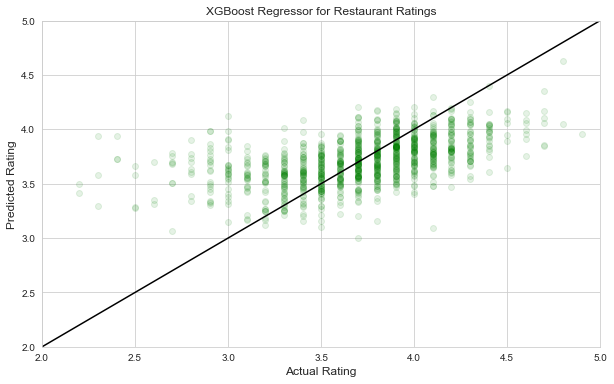

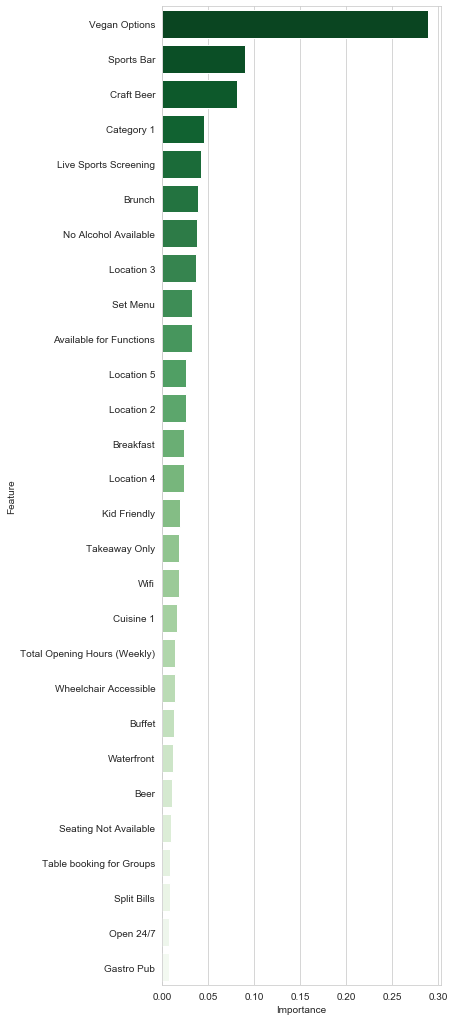

In [53]:
# Train a model using only restaurant characteristics
df = df[['Rating','Category 1','Cuisine 1','Location 2','Location 3','Location 4','Location 5',
         'Total Opening Hours (Weekly)',
         'Live Sports Screening',
         'Wheelchair Accessible',
         'Kid Friendly',
         'Waterfront',
         'Sports Bar',
         'Seating Not Available',
         'No Alcohol Available',
         'Craft Beer',
         'Takeaway Only',
         'Vegan Options',
         'Split Bills',
         'Table booking for Groups',
         'Breakfast',
         'Brunch',
         'Available for Functions',
         'Wifi',
         'Set Menu',
         'Gastro Pub',
         'Open 24/7',
         'Beer',
         'Buffet']]

num_features = df.select_dtypes(include=['int64','float64']).columns
num_pipeline = Pipeline([
        ('selector', ColumnSelector(num_features)), 
        ('imputer', Imputer(strategy="median")),           
        ('standardizer', StandardScaler())])

cat_features = [feat for feat in df.columns if feat not in num_features]
cat_pipeline = Pipeline([
        ('selector', ColumnSelector(cat_features)),
        ('ordinal_encoder', OrdinalEncoder())])

full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline)])

# Get response vector
df_y = df['Rating']
# Get feature matrix
df_X = full_pipeline.fit_transform(df.drop(columns='Rating'))

# Get train and test sets (90% - 10%)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.10)

# # # # XGBOOST REGRESSOR # # # #
param_grid = [{'n_estimators': [100, 200, 500],'max_depth': range(1,12,2)}]

# CV hyperparameter tuning for XGB
xgb = XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xgb, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
xgb_best = grid_search.best_estimator_
cvres = grid_search.cv_results_
      
# Predict best model on test set
y_pred = xgb_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('RMSE on test dataset:', round(rmse, 2))
r_sq = r2_score(y_test, y_pred)
print('R-squared on test dataset:', round(r_sq, 2))

# Plot actual vs. predicted
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(y_test, y_pred, ci=None, fit_reg=False, color='green', marker='o',  scatter_kws={'alpha':0.1});
plt.title('XGBoost Regressor for Restaurant Ratings', fontsize=12);
plt.xlabel('Actual Rating', fontsize=12);
plt.ylabel('Predicted Rating', fontsize=12);
plt.xlim(2, 5);
plt.ylim(2, 5);

# Add y=x line, representing perfect prediction accuracy
y_lim = plt.ylim();
x_lim = plt.xlim();
plt.plot(x_lim, y_lim, '-', color = 'k');

# Fit best model on the entire dataset
xgb_best.fit(df_X, df_y)

# Obtain and sort feature importances
all_features = list(num_features.values) + list(cat_features)
all_features.remove('Rating')
df_importances = pd.DataFrame(xgb_best.feature_importances_, all_features).reset_index(drop=False)
df_importances.rename(columns={'index':'Feature', 0:'Importance'}, inplace=True)
df_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(5, 18))
sns.barplot(x='Importance', y='Feature', data=df_importances, orient='h', palette='Greens_r');

## Conclusion

An extensive exploratory data analysis was performed, shedding light on relationships between restaurant characteristics, restaurant sentiment, and Zomato ratings. Two predictive models for rating were trained on either all or a subset of these features, although overall prediction accuracy left room to desire.

Key findings of the analysis include the following:
1. On average, the Fine Dining category had the highest restaurant rating; Club had the least.
2. Basque, Danish, Israeli, and Contemporary cuisines had the highest restaurant ratings; the lowest rated were Yum Cha, Burmese, Iraqi, Sichuan, and Diner.	
3. The municipal with the highest restaurant rating was Bellarine, followed by the CBD and inner suburbs. Suburbs/streets with highly rated restaurants were primarily located within the CBD.
4. Restaurants offering different dietary options (e.g. vegetarian friendly, gluten free options), either exclusively or in addition to their regular menu, tended to have higher restaurant ratings.
5. Restaurants offering customer-service oriented features such as availability for functions, split bills, indoor and outdoor seating, groups bookings, etc., tended to have higher restaurant ratings.
6. Restaurants with alcohol features such as craft beer, gin tasking, wine cellar, etc. tended to have higher restaurant ratings.
7. The average cost of a restaurant had little relationship to its rating.
8. A higher number of restaurant reviews was associated with a either a higher or lower restaurant rating. It appears that customers are collectively motivated to praise or criticise "great" or "bad" restaurants, with less activity for "average" restaurants. 
9. There was only a small relationship between sentiment scores (as derived from reviews left on Zomato) and restaurant rating. However, it should be noted that many restaurants did not contain any reviews with text that could be analysed for sentiment, making it difficult to build a predictive model using this feature.
10. A model using all available features had an average error of +/- 0.25 when predicting restaurant rating on a test set. The number of reviews/photos/blogs and sentiment scores emerged as the most important features for prediction. A model using only restaurant characteristics produced higher average errors (+/- 0.36), with Vegan Options, Sports Bar, and Craft Beer being the most important features for prediction. In future, one may attempt to use other supervised learning methods (such as a support vector machine) to improve prediction accuracy. 
 
Findings suggest that restaurant characteristics only mildly relate to a restaurant's Zomato rating. One noteworthy omission is a measurement of the _quality_ of food that each restaurant is producing. Future work could focus on incorporating this feature in some way, such as by analysing customer reviews for key words (e.g. soggy, bland, tasty, delicious).

### Sources
Hutto, C. J. & Gilbert, E. E. (2014). VADER: A parsimonious rule-based model for sentiment analysis of social media text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.